# Eindopdracht Tijdreeksen 2122
Ymke van der Waal en Lea van den Heuvel

**De opdracht:**

**Duurzame energie is hot. Maak een voorspellingsmodel dat 1 week vooruit voorspelt wat het energieverbruik door zonnepanelen is. Hanteer hierbij als maatstaf MAPE. Beschrijf de invloed van de weersvariabelen op het energieverbruik door zonnepanelen.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import dateparser
from datetime import timedelta
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
import datetime
# from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import shapiro

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['image.cmap'] = 'Paired'
np.random.seed(42)

In [2]:
def mean_absolute_percentage_error(actual, pred): 
    """
    Returns MAPE
    """
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((pred - actual) / actual)) * 100

In [3]:
def mean_absolute_error(actual, pred): 
    """
    Returns MAE
    """
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(pred - actual))

# 1 Data importeren en eerste bewerkingen

### 1.1 Energie data
Bij het downloaden van de data gaat deze niet verder terug dan twee jaar, dus moeten eerder gedownloade dataset samengevoegd met een dataset van later.

Variabelen:
- Stroom 1 (in kWh): Electricitreitsverbruik, gemeten bij meter 1
- Stroom 2 (in kWh): Electricitreitsverbruik, gemeten bij meter 2
- Teruglevering 1 (in kWh): Terug-geleverde electriciteit, gewonnen met zonnepanelen groep 1
- Teruglevering 2 (in kWh): Terug-geleverde electriciteit, gewonnen met zonnepanelen groep 2
- Gas 1 (in m3): Gasverbruik
- Opmerkingen

#### 1.1.1 Eerste dataset

In [4]:
# Eerste dataset
ts1 = pd.read_csv('mijn-meterstanden.csv')
ts1.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0  25 mei 2021           9.172           8.999                  823.0   
1  24 mei 2021           9.166           8.999                  816.0   
2  23 mei 2021           9.153           8.999                  807.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.009       6.931  Smartmeter  
1                  2.009       6.928  Smartmeter  
2                  2.009       6.927  Smartmeter

In [5]:
# Zet datum om
ts1['Meetdatum'] = ts1.Meetdatum.apply(lambda x: dateparser.parse(x))
ts1.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-25           9.172           8.999                  823.0   
1 2021-05-24           9.166           8.999                  816.0   
2 2021-05-23           9.153           8.999                  807.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.009       6.931  Smartmeter  
1                  2.009       6.928  Smartmeter  
2                  2.009       6.927  Smartmeter

#### 1.1.2 Tweede dataset

In [6]:
# Tweede dataset
ts2 = pd.read_csv('mijn-meterstanden_3.csv')
ts2.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0  31 mei 2021           9.195           9.019                  865.0   
1  30 mei 2021           9.181           9.019                  843.0   
2  29 mei 2021           9.177           9.019                  823.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.067       6.936  Smartmeter  
1                  2.067       6.935  Smartmeter  
2                  2.067       6.934  Smartmeter

In [7]:
# Zet datum om
ts2['Meetdatum'] = ts2.Meetdatum.apply(lambda x: dateparser.parse(x))
ts2.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-31           9.195           9.019                  865.0   
1 2021-05-30           9.181           9.019                  843.0   
2 2021-05-29           9.177           9.019                  823.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.067       6.936  Smartmeter  
1                  2.067       6.935  Smartmeter  
2                  2.067       6.934  Smartmeter

#### 1.1.3 Samenvoegen

In [8]:
# Voeg de twee datasets samen
ts = ts2[ts2.Meetdatum > ts1.Meetdatum.max()] # Set met data die extra worden toegevoegd aan ts1
ts = pd.concat([ts, ts1]) # Voeg de twee sets samen
ts.head(10)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-31           9.195           9.019                  865.0   
1 2021-05-30           9.181           9.019                  843.0   
2 2021-05-29           9.177           9.019                  823.0   
3 2021-05-28           9.176           9.017                  823.0   
4 2021-05-27           9.175           9.014                  823.0   
5 2021-05-26           9.174           9.004                  823.0   
0 2021-05-25           9.172           8.999                  823.0   
1 2021-05-24           9.166           8.999                  816.0   
2 2021-05-23           9.153           8.999                  807.0   
3 2021-05-22           9.146           8.999                  799.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.067       6.936  Smartmeter  
1                  2.067       6.935  Smartmeter  
2                  2.067       6.934  Smartmeter  
3                  2.042       6.934  Smartmeter  
4                  2.033       6.932  Smartmeter  
5                  2.022       6.931  Smartmeter  
0                  2.009       6.931  Smartmeter  
1                  2.009       6.928  Smartmeter  
2                  2.009       6.927  Smartmeter  
3                  2.009       6.925  Smartmeter

#### 1.1.4 Data inspecteren

In [9]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 756
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Meetdatum              763 non-null    datetime64[ns]
 1   Stroom 1 (kWh)         763 non-null    float64       
 2   Stroom 2 (kWh)         763 non-null    float64       
 3   Teruglevering 1 (kWh)  342 non-null    float64       
 4   Teruglevering 2 (kWh)  344 non-null    float64       
 5   Gas 1 (m3)             763 non-null    float64       
 6   Opmerkingen            763 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 47.7+ KB


In [10]:
def check_dates(x):
    '''Functie om te checken of datum vóór en na in ts staan, zodat het gefilterd kan worden en het een timeseries is
    Returned boolean, True wanneer datum vóór en na gecheckte datum in de dataframe staan'''
    d = timedelta(days=1)
    # Check of dag ervoor en dag erna in ts staan, dan is het ts
    if ((x-d) in ts.Meetdatum.values) and ((x+d) in ts.Meetdatum.values):
        return True
    else: return False

In [11]:
# Nieuwe kolom met of de datum ervoor en erna in ts staan
ts['check_dates'] = ts['Meetdatum'].apply(lambda x: check_dates(x))
ts.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-31           9.195           9.019                  865.0   
1 2021-05-30           9.181           9.019                  843.0   
2 2021-05-29           9.177           9.019                  823.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  check_dates  
0                  2.067       6.936  Smartmeter        False  
1                  2.067       6.935  Smartmeter         True  
2                  2.067       6.934  Smartmeter         True

In [12]:
ts = ts[ts['check_dates']] # Behoud alleen rijen waarbij de dag ervoor en erna ook in de dataset staan
ts.drop(columns = ['Opmerkingen', 'check_dates'], inplace = True) # Drop onnodige kolommen
ts.set_index('Meetdatum', inplace =True) # Set index
ts.head(3)

Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
Meetdatum                                                           
2021-05-30           9.181           9.019                  843.0   
2021-05-29           9.177           9.019                  823.0   
2021-05-28           9.176           9.017                  823.0   

            Teruglevering 2 (kWh)  Gas 1 (m3)  
Meetdatum                                      
2021-05-30                  2.067       6.935  
2021-05-29                  2.067       6.934  
2021-05-28                  2.042       6.934

In [13]:
# Door het excel format zijn alle getallen groter dan 1000 omgezet naar floats
# Het zijn geen floats maar integers, dus alle getallen boven de 1000 moeten worden vermenigvuldigd met 1000
cols = [ 'Stroom 1 (kWh)', 'Stroom 2 (kWh)', 'Teruglevering 1 (kWh)', 'Teruglevering 2 (kWh)', 'Gas 1 (m3)']

for col in cols:
    ts[col] = ts[col].apply(lambda x: (x*1000) if (x < 10) else x)
    
ts.head(3)

Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
Meetdatum                                                           
2021-05-30          9181.0          9019.0                  843.0   
2021-05-29          9177.0          9019.0                  823.0   
2021-05-28          9176.0          9017.0                  823.0   

            Teruglevering 2 (kWh)  Gas 1 (m3)  
Meetdatum                                      
2021-05-30                 2067.0      6935.0  
2021-05-29                 2067.0      6934.0  
2021-05-28                 2042.0      6934.0

In [14]:
# Nieuwe kolommen
# Stroom in kWh
ts['stroom'] = ts['Stroom 1 (kWh)'] + ts['Stroom 2 (kWh)']
# Teruglevering in kWh
ts['teruglevering'] = ts['Teruglevering 1 (kWh)'] + ts['Teruglevering 2 (kWh)']
# Gas in m3
ts.rename(columns = {'Gas 1 (m3)': 'gas'}, inplace = True)
# Filter nodige kolommen
ts = ts[['gas', 'stroom', 'teruglevering']].copy()
ts.head(3)

gas   stroom  teruglevering
Meetdatum                                 
2021-05-30  6935.0  18200.0         2910.0
2021-05-29  6934.0  18196.0         2890.0
2021-05-28  6934.0  18193.0         2865.0

In [15]:
ts.describe()

gas        stroom  teruglevering
count   735.000000    735.000000     338.000000
mean   5354.122449  14913.485714    1578.597633
std     846.942378   2121.267077     641.287872
min    4154.000000  11088.000000       0.000000
25%    4527.000000  12998.000000    1329.250000
50%    5494.000000  15372.000000    1641.000000
75%    5775.500000  16616.500000    1901.250000
max    6935.000000  18200.000000    2910.000000

In [16]:
# Missende waarden
ts.isna().sum()

gas                0
stroom             0
teruglevering    397
dtype: int64

In [17]:
ts[ts['teruglevering'].isnull()]
# Er zijn missende waarden omdat er toen nog geen zonnepanelen (=teruglevering) was

gas   stroom  teruglevering
Meetdatum                                 
2020-06-27  5508.0  15666.0            NaN
2020-06-26  5508.0  15664.0            NaN
2020-06-25  5507.0  15661.0            NaN
2020-06-24  5507.0  15644.0            NaN
2020-06-23  5507.0  15638.0            NaN
...            ...      ...            ...
2019-05-31  4156.0  11139.0            NaN
2019-05-30  4156.0  11119.0            NaN
2019-05-29  4155.0  11113.0            NaN
2019-05-28  4155.0  11106.0            NaN
2019-05-27  4154.0  11088.0            NaN

[397 rows x 3 columns]

In [18]:
# Duplicates bekijken
ts[ts.duplicated()]

Empty DataFrame
Columns: [gas, stroom, teruglevering]
Index: []

In [19]:
# Opslaan als csv
# ts.to_csv('energieverbruik_v2.csv')

### 1.2 Weer data 

De data:

- Datum
- Etmaalgemiddelde temperatuur in 0.1 graden Celcius
- Zonneschijnduur in 0.1 uur
- Duur van neerslag in 0.1 uur
- Etmaalsom van de neerslag in 0.1 mm

In [20]:
ts_weer = pd.read_csv('Weer_data.csv')
ts_weer.head(3)

YYYYMMDD   TG  SQ  DR  RH
0  1991-08-13  147   8   0  -1
1  1991-08-14  162  91   0   0
2  1991-08-15  181  94   0   0

In [21]:
ts_weer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10774 entries, 0 to 10773
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   YYYYMMDD  10774 non-null  object
 1   TG        10774 non-null  int64 
 2   SQ        10774 non-null  int64 
 3   DR        10774 non-null  int64 
 4   RH        10774 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 421.0+ KB


In [22]:
ts_weer.columns

Index(['YYYYMMDD', 'TG', 'SQ', 'DR', 'RH'], dtype='object')

In [23]:
# Rename columns
weer_colnames = {'YYYYMMDD' : 'Date', 'TG' : 'temp', 'SQ' : 'zonneschijn', 
                 'DR' : 'duur_neerslag', 'RH' : 'som_neerslag'}
ts_weer.rename(columns = weer_colnames, inplace = True)
# Date als datetime
ts_weer['Date'] = pd.to_datetime(ts_weer['Date'], format = '%Y-%m-%d')
#Set date als index
ts_weer.set_index('Date', inplace = True)
ts_weer.head(3)

temp  zonneschijn  duur_neerslag  som_neerslag
Date                                                      
1991-08-13   147            8              0            -1
1991-08-14   162           91              0             0
1991-08-15   181           94              0             0

### 1.3 Datasets mergen

In de datasets die we gaan gebruiken stata dus:

- Gasverbruik (in m3)
- Stroomverbruik (in kWh)
- **Teruglevering stroom (in kWh) is Y**
- Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) 
- Zonneschijnduur (in 0.1 uur)
- Duur van de neerslag (in 0.1 uur) 
- Etmaalsom van de neerslag (in 0.1 mm) 

In [24]:
ts = ts.merge(ts_weer, 
              left_index = True, right_index = True,
              how = 'inner') # Alleen data mergen die in beide sets voorkomen
ts.head(3)

gas   stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2021-05-30  6935.0  18200.0         2910.0   142          147              0   
2021-05-29  6934.0  18196.0         2890.0   116           73              0   
2021-05-28  6934.0  18193.0         2865.0   121          124              0   

            som_neerslag  
2021-05-30             0  
2021-05-29             0  
2021-05-28             0

## 2 Dataverkenning

In [25]:
# Kolommen verdelen
cols_e = ['gas', 'stroom', 'teruglevering']
cols_w = ['temp', 'zonneschijn', 'duur_neerslag', 'som_neerslag']

### 2.1 Energieverbruik

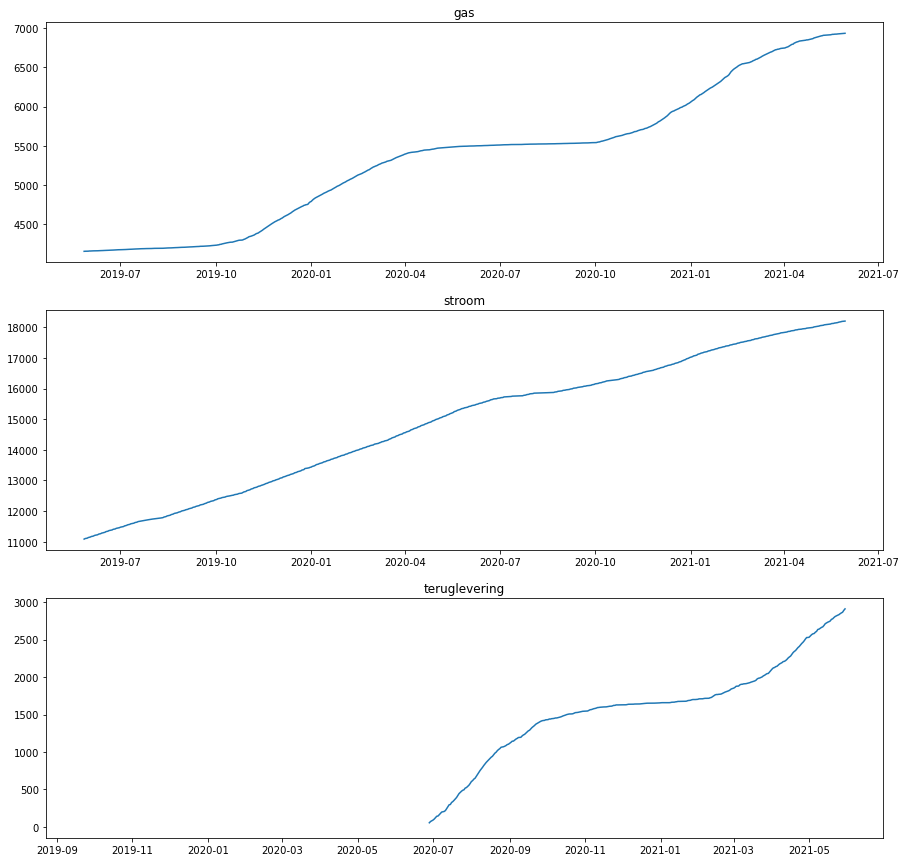

In [26]:
fig, ax = plt.subplots(3,1, figsize = (15,15))

for col in cols_e:
    i = cols_e.index(col)
    ax[i].plot(ts[col])
    ax[i].set_title(col)
    
plt.show()

In [27]:
# Meter is cumulatief dus differentieren om gebruik per dag te krijgen
# Absolute waardes pakken
ts[cols_e] = np.abs(ts[cols_e].diff())
ts.head()

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2021-05-30  NaN     NaN            NaN   142          147              0   
2021-05-29  1.0     4.0           20.0   116           73              0   
2021-05-28  0.0     3.0           25.0   121          124              0   
2021-05-27  2.0     4.0            9.0   109           34             84   
2021-05-26  1.0    11.0           11.0   109           52             59   

            som_neerslag  
2021-05-30             0  
2021-05-29             0  
2021-05-28             0  
2021-05-27            75  
2021-05-26            61

<Figure size 1080x576 with 0 Axes>

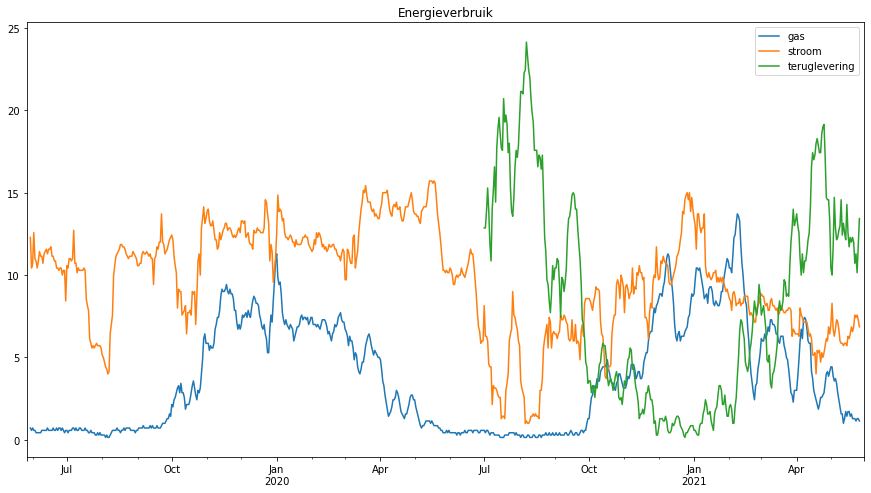

In [28]:
plt.set_cmap('Paired')

ts_rolling = ts[cols_e].rolling(window = 7, center = True).mean()
ts_rolling.plot()
plt.title('Energieverbruik')
plt.legend()
plt.show()

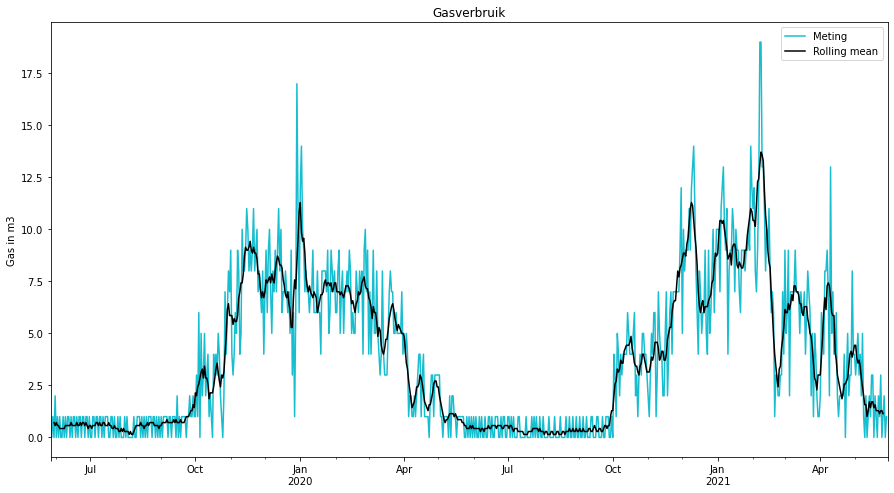

In [29]:
ts['gas'].plot(color = 'tab:cyan', label = 'Meting')

#ts_mean = ts['gas'].rolling(window = 7, center = True).mean()
ts_rolling['gas'].plot(color = "k", label = "Rolling mean")

plt.title('Gasverbruik')
plt.ylabel('Gas in m3')
plt.legend()
plt.show()

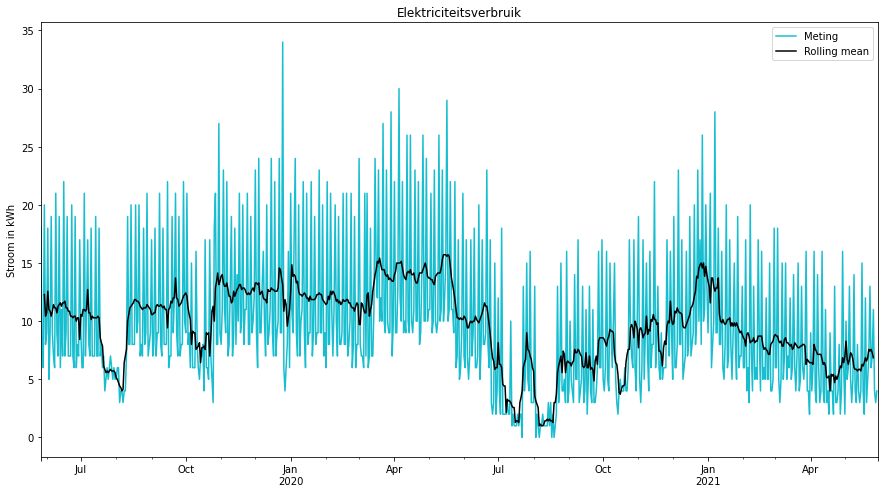

In [30]:
ts['stroom'].plot(color = 'tab:cyan', label = 'Meting')

#ts_mean = ts['stroom'].rolling(window = 7, center = True).mean()
ts_rolling['stroom'].plot(color = "k", label = "Rolling mean")

plt.title('Elektriciteitsverbruik')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

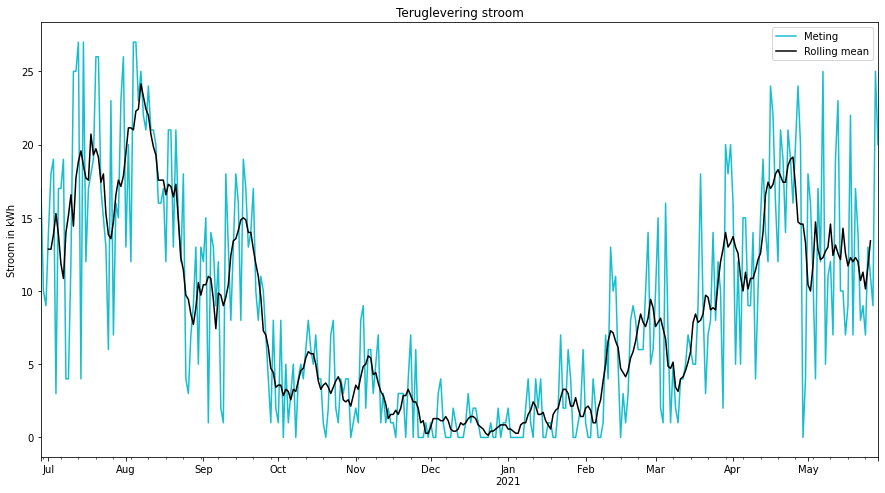

In [31]:
ts['teruglevering'].dropna().plot(color = 'tab:cyan', label = 'Meting')

# ts_mean = ts['teruglevering'].dropna().rolling(window = 7, center = True).mean()
ts_rolling['teruglevering'].dropna().plot(color = "k", label = "Rolling mean")

plt.title('Teruglevering stroom')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

#### 2.1.1 Verdeling van de data

In [32]:
def season(x):
    '''Input is de maand, returned in welk seizoen de maand is'''
    
    if x == 12 or x <= 2:
        return "Winter"
    elif x >= 8:
        return "Autumn"
    elif x >= 6:
        return "Summer"
    else: return "Spring"

In [33]:
# Nieuwe kolom voor dag vd week
ts['day_of_week'] = ts.index.dayofweek
ts['day_of_week_name'] = ts.index.day_name()
# kolom met dag vd maand
ts['day_of_month'] = ts.index.day
# kolom met maand
ts['month'] = ts.index.month 
ts['month_name'] = ts.index.month_name()
 # kolom met seizoen
ts['season'] = ts['month'].apply(lambda x: season(x))
ts['season'] = ts['season'].astype('category')
ts.head(3)

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2021-05-30  NaN     NaN            NaN   142          147              0   
2021-05-29  1.0     4.0           20.0   116           73              0   
2021-05-28  0.0     3.0           25.0   121          124              0   

            som_neerslag  day_of_week day_of_week_name  day_of_month  month  \
2021-05-30             0            6           Sunday            30      5   
2021-05-29             0            5         Saturday            29      5   
2021-05-28             0            4           Friday            28      5   

           month_name  season  
2021-05-30        May  Spring  
2021-05-29        May  Spring  
2021-05-28        May  Spring

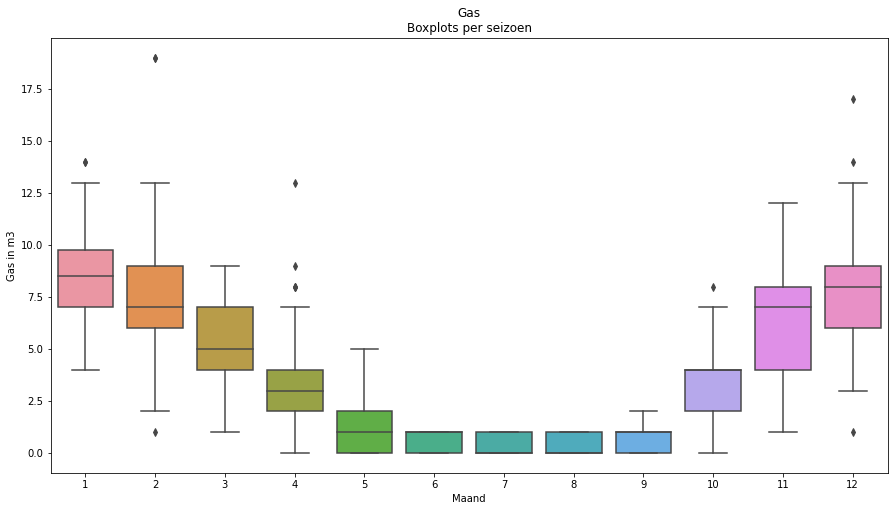

In [34]:
sns.boxplot(data = ts, y = 'gas', x = 'month')
plt.title('Gas\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Gas in m3')
plt.show()

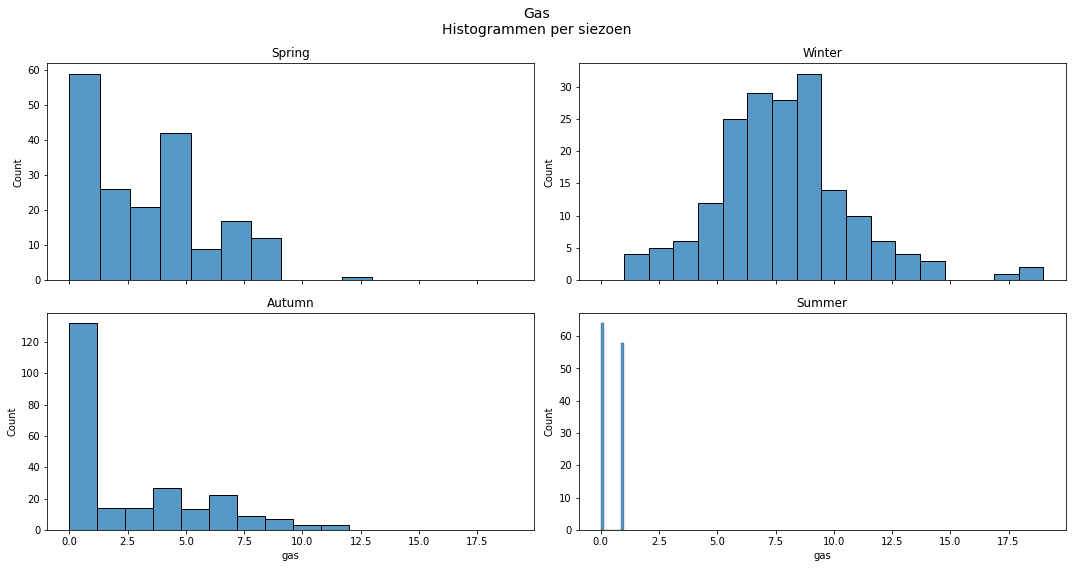

In [35]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'gas',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Gas\nHistogrammen per siezoen', size = 14)
plt.tight_layout()
plt.show()

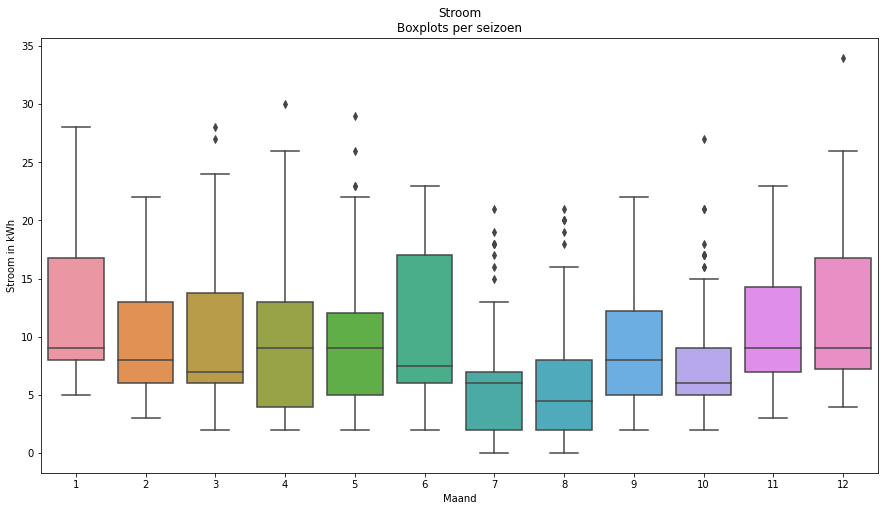

In [36]:
sns.boxplot(data = ts, y = 'stroom', x = 'month')
plt.title('Stroom\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

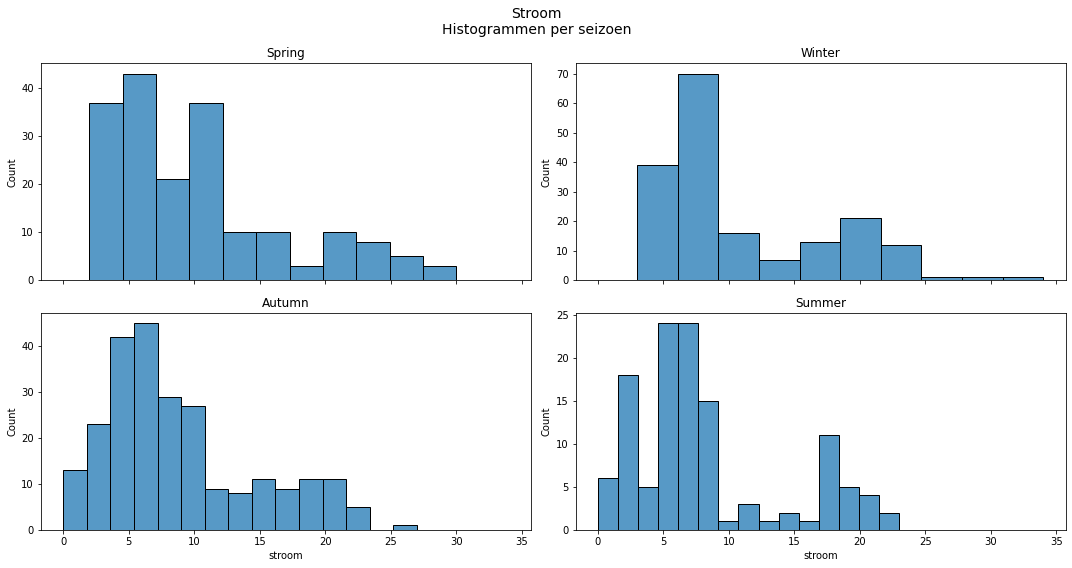

In [37]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'stroom',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Stroom\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

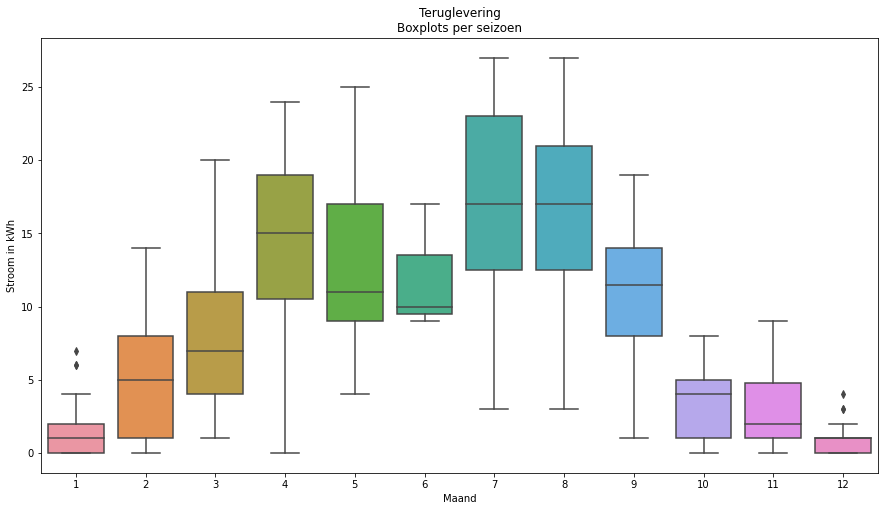

In [38]:
sns.boxplot(data = ts, y = 'teruglevering', x = 'month')
plt.title('Teruglevering\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

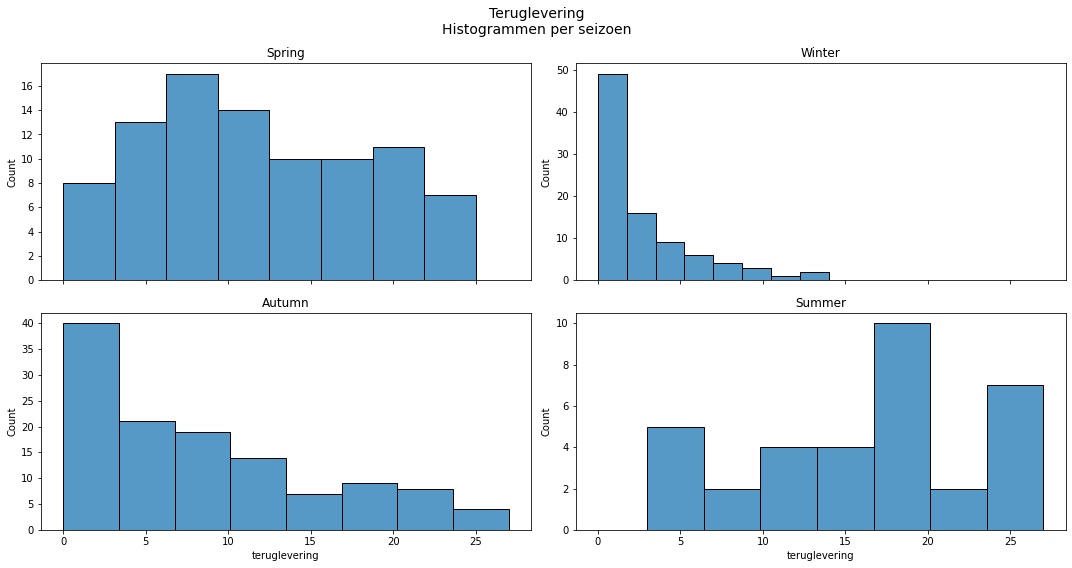

In [39]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'teruglevering',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Teruglevering\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

#### 2.1.2 Gemiddelden

In [40]:
# Labels voor legenda
legend_labels_e = ['Gasverbruik (m3)', 'Stroomverbruik (kWh)', 'Teruglevering stroom (kWh)']

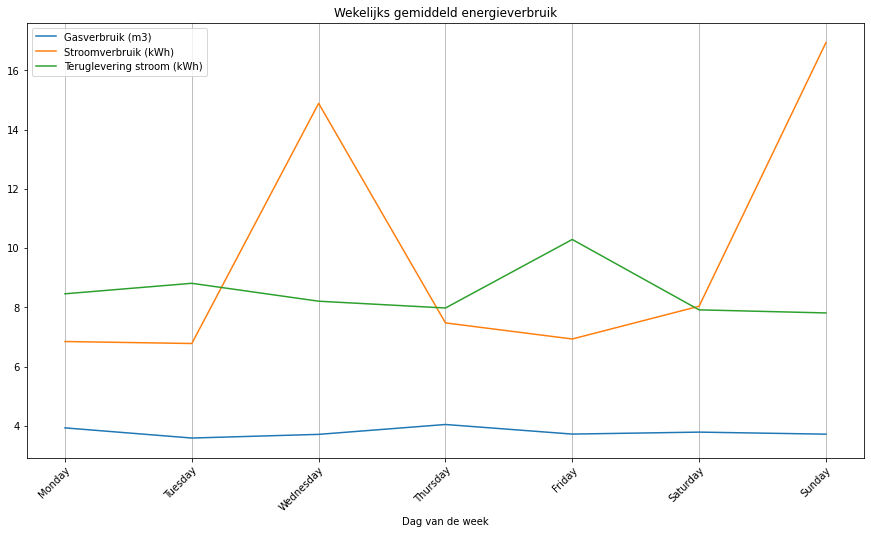

In [41]:
ts_grouped_gas = ts.groupby(['day_of_week', 'day_of_week_name'])[cols_e].mean().reset_index().set_index('day_of_week', drop= True)
ax = ts_grouped_gas.plot()

plt.title('Wekelijks gemiddeld energieverbruik')
plt.xlabel('Dag van de week')
plt.xticks(np.arange(0, 7),
           ts_grouped_gas['day_of_week_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

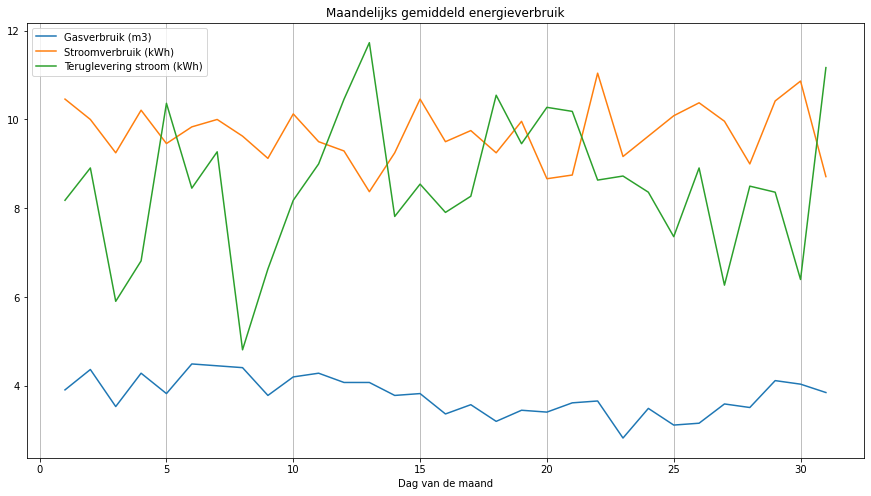

In [42]:
ts_grouped_gas = ts.groupby('day_of_month')[cols_e].mean()
ax = ts_grouped_gas.plot()
plt.title('Maandelijks gemiddeld energieverbruik')
plt.xlabel('Dag van de maand')
plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

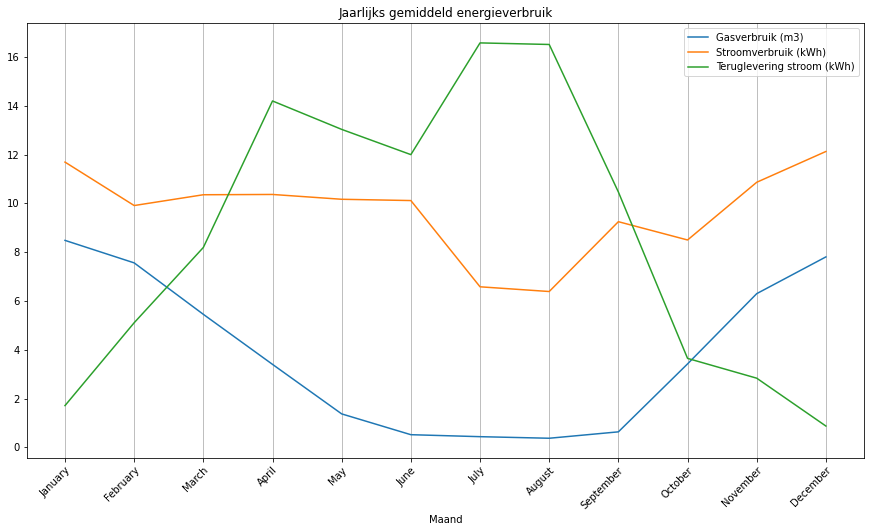

In [43]:
ts_grouped_gas = ts.groupby(['month', 'month_name'])[cols_e].mean().reset_index().set_index('month', drop= True)
ax = ts_grouped_gas.plot()
plt.title('Jaarlijks gemiddeld energieverbruik')
plt.xticks(np.arange(1, 13),
           ts_grouped_gas['month_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

plt.xlabel('Maand')
plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

Teruglevering heeft een duidelijk jaarlijks seizoenspatroon. ARIMA kan één seizoenspatroon aan, dus er worden geen fourier terms toegevoegd.

### 2.2 Weer data

In [44]:
# Dataset met moving average voor weer data
ts_rolling_w = ts[cols_w].rolling(window = 7, center = True).mean()
ts_rolling_w.head(10)

temp  zonneschijn  duur_neerslag  som_neerslag
2021-05-30         NaN          NaN            NaN           NaN
2021-05-29         NaN          NaN            NaN           NaN
2021-05-28         NaN          NaN            NaN           NaN
2021-05-27  116.857143    68.714286      37.571429     35.285714
2021-05-26  112.142857    52.571429      38.857143     36.142857
2021-05-25  110.428571    43.428571      46.857143     43.142857
2021-05-24  111.428571    36.714286      49.285714     46.000000
2021-05-23  113.142857    39.142857      38.000000     35.571429
2021-05-22  111.857143    35.285714      31.857143     28.857143
2021-05-21  112.142857    42.428571      31.000000     32.142857

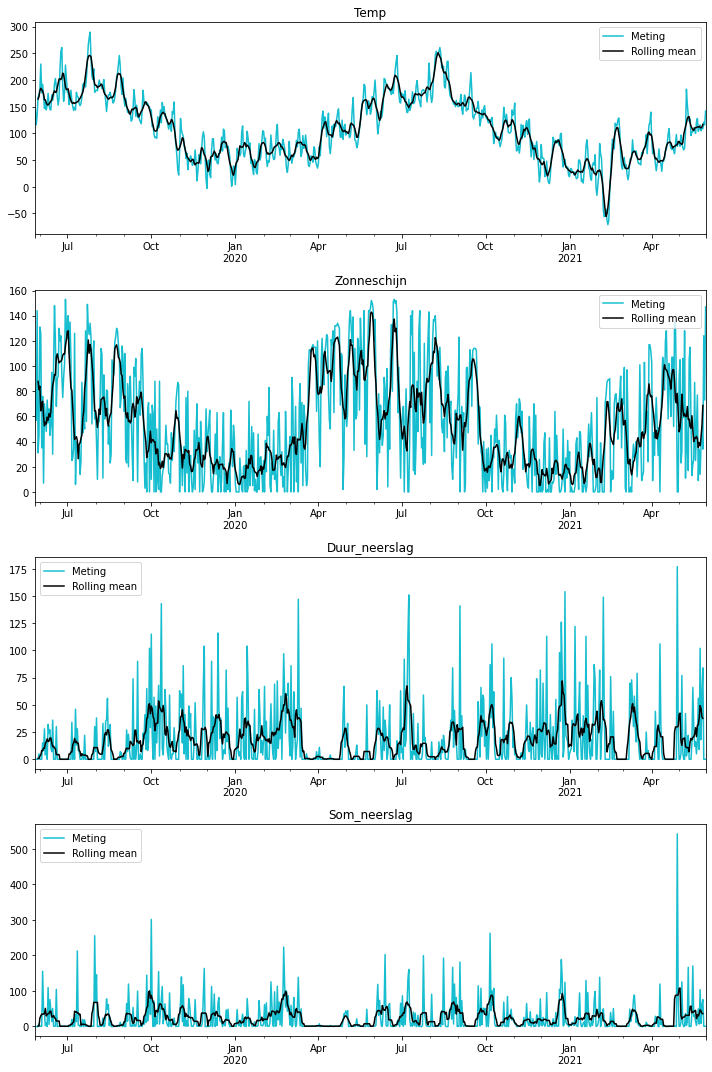

In [45]:
# Plot weer data met rolling mean
fig, ax = plt.subplots(4,1, figsize = (10,15))
# Dictionairy voor variabele met bijbehorende ax
dict_ax = {'temp' : ax[0],
           'zonneschijn' : ax[1],
           'duur_neerslag' : ax[2],
           'som_neerslag' : ax[3],
          }

for i in cols_w:
    # Plot originele data
    ts[i].plot(color = 'tab:cyan', label = 'Meting', 
               ax = dict_ax[i])
    # Plot rolling mean
    ts_rolling_w[i].plot(color = "k", label = "Rolling mean",
                         ax = dict_ax[i])
    dict_ax[i].set_title(i.capitalize())
    dict_ax[i].legend()
    
plt.tight_layout()
plt.show()

#### 2.2.1 Gemiddelden

In [46]:
# Labels voor in legenda
legend_labels_w = ['Temperatuur (0.1 graden Celsius)', 'Zonneschijnduur (0.1 uur)',
                   'Duur neerslag (0.1 uur)', 'Som neerslag (0.1 mm)']

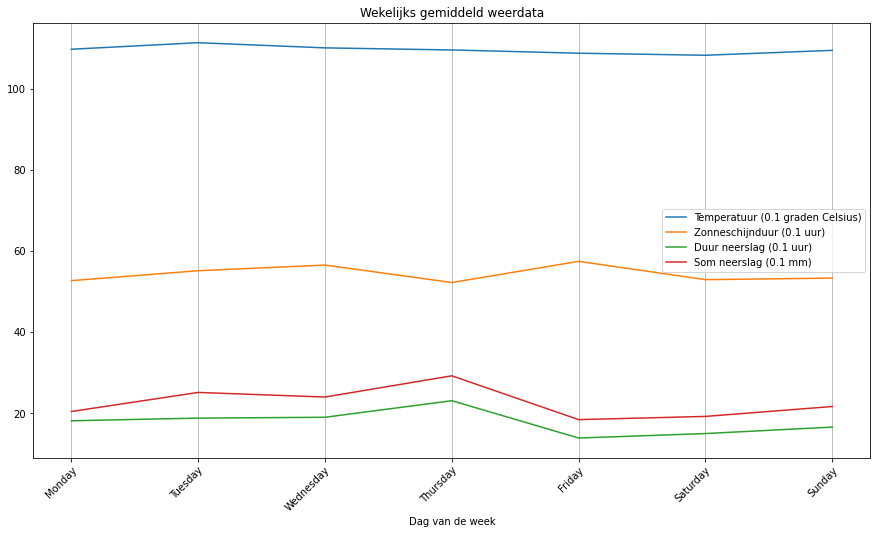

In [47]:
ts_grouped_gas = ts.groupby(['day_of_week', 'day_of_week_name'])[cols_w].mean().reset_index().set_index('day_of_week', drop= True)
ax = ts_grouped_gas.plot()

plt.title('Wekelijks gemiddeld weerdata')
plt.xlabel('Dag van de week')
plt.xticks(np.arange(0, 7),
           ts_grouped_gas['day_of_week_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

ax.legend(legend_labels_w)
plt.grid(axis = 'x')
plt.show()

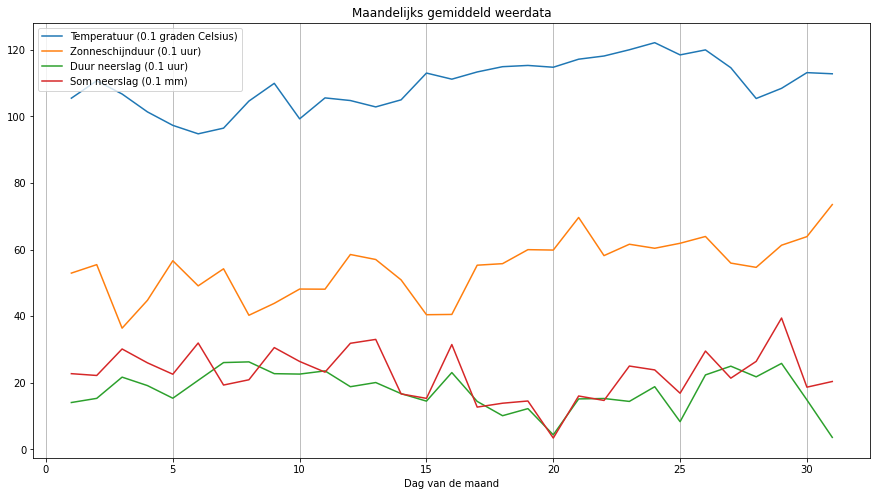

In [48]:
ts_grouped_w = ts.groupby('day_of_month')[cols_w].mean()#.reset_index().set_index('month', drop= True)
ax = ts_grouped_w.plot()

plt.title('Maandelijks gemiddeld weerdata')
plt.xlabel('Dag van de maand')
plt.grid(axis = 'x')

ax.legend(legend_labels_w)
plt.show()

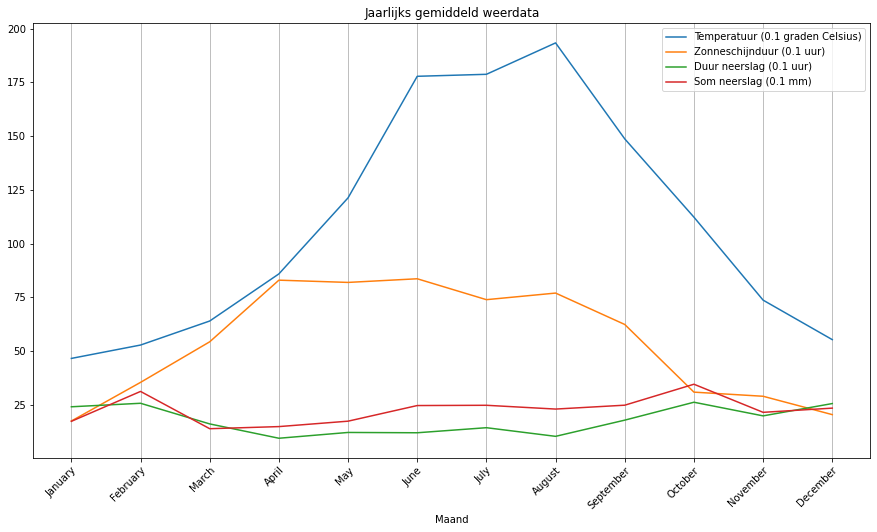

In [49]:
ts_grouped_w = ts.groupby(['month', 'month_name'])[cols_w].mean().reset_index().set_index('month', drop= True)
ax = ts_grouped_w.plot()

plt.title('Jaarlijks gemiddeld weerdata')
plt.xticks(np.arange(1, 13),
           ts_grouped_w['month_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')
plt.xlabel('Maand')
plt.grid(axis = 'x')

ax.legend(legend_labels_w)
plt.show()

Uit de bovenstaande visualisaties valt te concluderen dat de weerdata alleen een jaarlijks seizoenspatroon bevat.
### 2.3 Zonnepanelen
Seasonal decompose kan niet uitgevoerd worden omdat er niet genoeg data is.

In [50]:
# Drop NaNs omdat de zonnepanelen later zijn geinstalleerd dan de dataset begint
ts.dropna(inplace = True)
ts.head(3)

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2021-05-29  1.0     4.0           20.0   116           73              0   
2021-05-28  0.0     3.0           25.0   121          124              0   
2021-05-27  2.0     4.0            9.0   109           34             84   

            som_neerslag  day_of_week day_of_week_name  day_of_month  month  \
2021-05-29             0            5         Saturday            29      5   
2021-05-28             0            4           Friday            28      5   
2021-05-27            75            3         Thursday            27      5   

           month_name  season  
2021-05-29        May  Spring  
2021-05-28        May  Spring  
2021-05-27        May  Spring

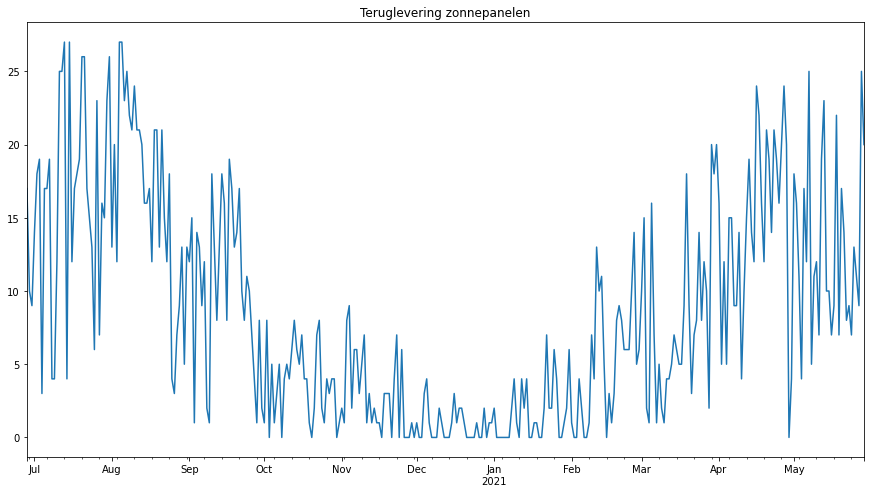

In [51]:
ts['teruglevering'].plot()
plt.title('Teruglevering zonnepanelen')
plt.show()

In [52]:
# Voer adfullertest uit
res_stat = adfuller(ts['teruglevering'])

print('P-waarde adfuller test:')
print(res_stat[1])
print('In combinatie met de plot is conclusie dat de bewerkte tijdreeks voor teruglevering (trend)stationair is.')

P-waarde adfuller test:
0.1386891300107993
In combinatie met de plot is conclusie dat de bewerkte tijdreeks voor teruglevering (trend)stationair is.


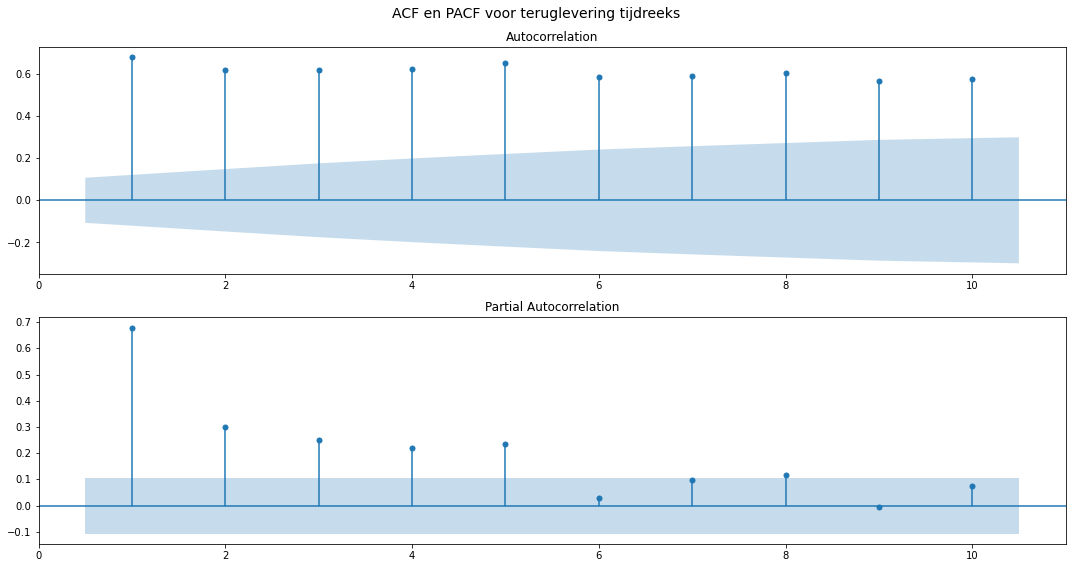

In [53]:
# ACF en PACF
fig, ax = plt.subplots(2,1)

plot_acf(ts['teruglevering'], lags = 10, zero = False, ax = ax[0])
plot_pacf(ts['teruglevering'], lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor teruglevering tijdreeks', size = 14)
plt.tight_layout()
plt.show()

ACF is alleen maar significant, dus differentieren en weer plotten.

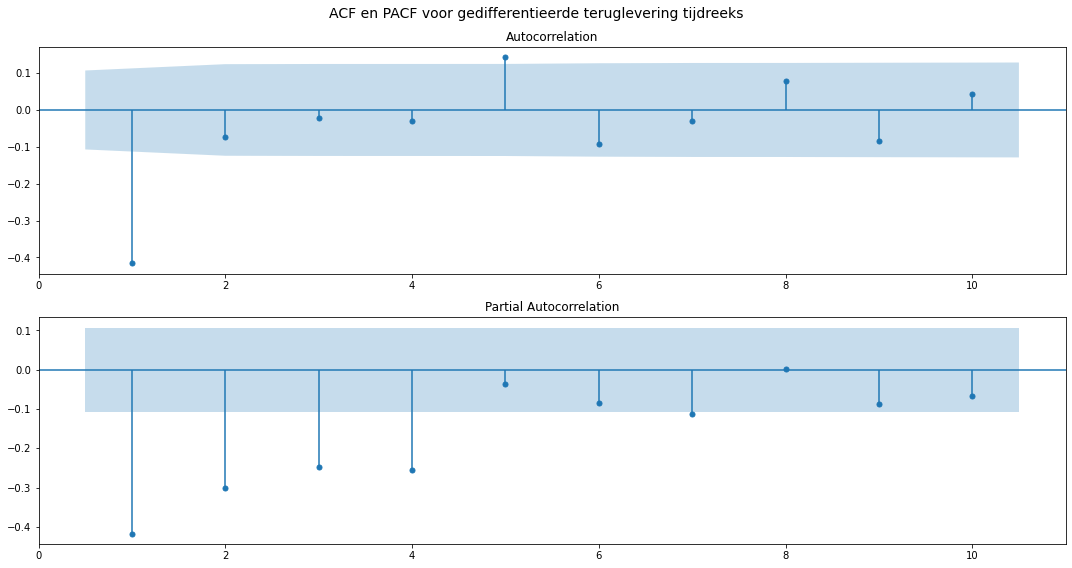

In [54]:
# ACF en PACF voor gedifferencieerde tijdreeks
fig, ax = plt.subplots(2,1)

plot_acf(ts['teruglevering'].diff().dropna(), lags = 10, zero = False, ax = ax[0])
plot_pacf(ts['teruglevering'].diff().dropna(), lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor gedifferentieerde teruglevering tijdreeks', size = 14)
plt.tight_layout()
plt.show()

Dat is beter ja :) Gedifferencieerde tijdreeks wordt gebruikt voor de voorspelling, waarbij waarschijnlijk:

- p = 4
- q = 0

Lag 5 is bij de ACF en PACF ook significant, maar heeft geen hele hoge waarde.

### 2.4 Zonnepanelen en weer data samen

#### 2.4.1 Correlatie

In [55]:
# Nummerieke kolommen
cols = ['gas', 'stroom', 'teruglevering', 
        'temp', 'zonneschijn','duur_neerslag', 'som_neerslag']

In [56]:
# Correlatie van teruglevering met de andere variabelen, gesorteerd van positief naar negatief
ts_corr = ts[cols].corr()
corr_teruglevering = ts_corr.drop('teruglevering')[['teruglevering']].sort_values('teruglevering', ascending = False)
corr_teruglevering

teruglevering
zonneschijn         0.881190
temp                0.516625
som_neerslag       -0.229179
duur_neerslag      -0.389007
stroom             -0.489764
gas                -0.611261

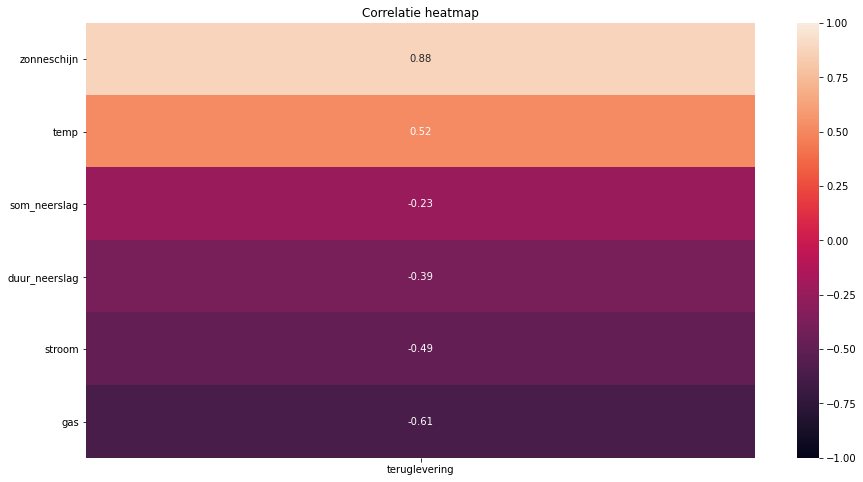

In [57]:
sns.heatmap(corr_teruglevering, annot = True, 
            vmin=-1, vmax=1 # Set range van kleur
           )
plt.title('Correlatie heatmap')
plt.yticks(rotation = 'horizontal')
plt.show()

In [58]:
print(f"Correlatie van temperatuur en zonneschijn: {ts_corr.loc['temp', 'zonneschijn']}")

Correlatie van temperatuur en zonneschijn: 0.3369995685480673


Teruglevering heeft een hoge positieve correlatie met zonneschijn en temperatuur, dus kunnen als extra variabelen toegevoegd worden aan het ARIMA model. Temperatuur en zonneschijn hebben een correlatie van 0.33, redelijk lage correlatie dus geen multicollineariteit.

Gas en stroom worden niet gebruikt om teruglevering te voorspellen; er wordt een weersvoorspelling gedaan voor dus op basis daarvan kunnen we teruglevering voorspellen. Gas- en elektriciteitsverbruik is pas bekend aan het einde van de dag, en niet op het moment dat een voorspelling gedaan wordt.

#### 2.4.2 Verdere visualisaties met temperatuur en zonneschijn

In [59]:
corr_zon = ts_corr.loc['teruglevering', 'zonneschijn']
corr_temp = ts_corr.loc['teruglevering', 'temp']
print(corr_zon)
print(corr_temp)

0.8811900533042153
0.5166254631098118


##### 2.4.2.1 Teruglevering en zonneeschijn

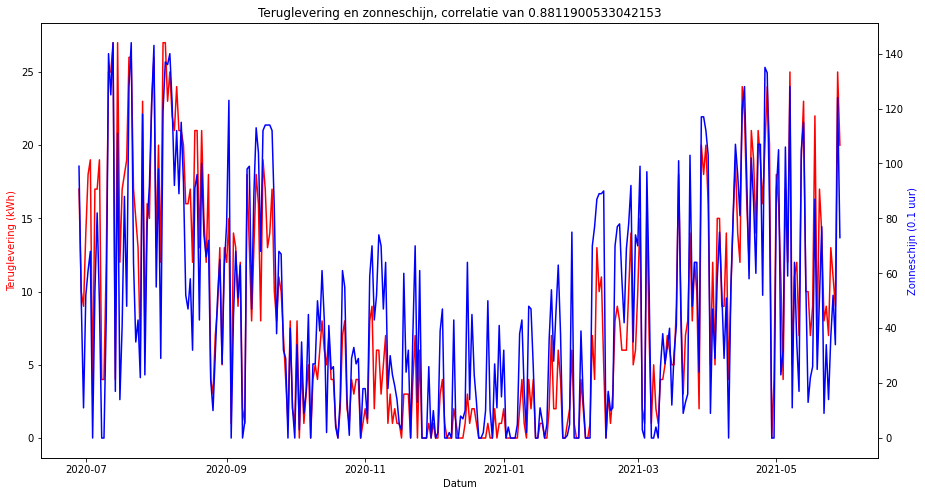

In [60]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ts.teruglevering, 'r')
ax2.plot(ts.zonneschijn, 'b')

ax1.set_xlabel('Datum')
ax1.set_ylabel('Teruglevering (kWh)', color='r')
ax2.set_ylabel('Zonneschijn (0.1 uur)', color='b')

plt.title(f'Teruglevering en zonneschijn, correlatie van {corr_zon}')
plt.show()

##### Outliers obv variabelen delen op elkaar

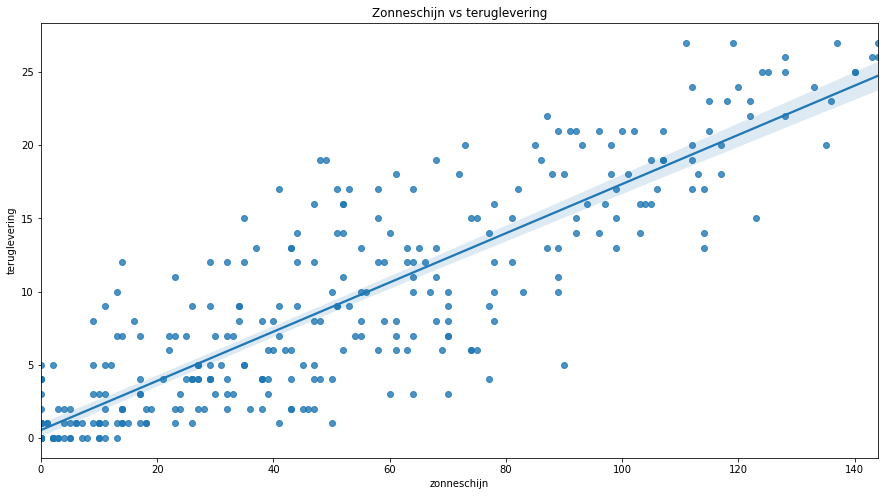

In [61]:
# Scatterplot
sns.regplot(data = ts, x = 'zonneschijn', y = 'teruglevering')
plt.title('Zonneschijn vs teruglevering')
plt.show()

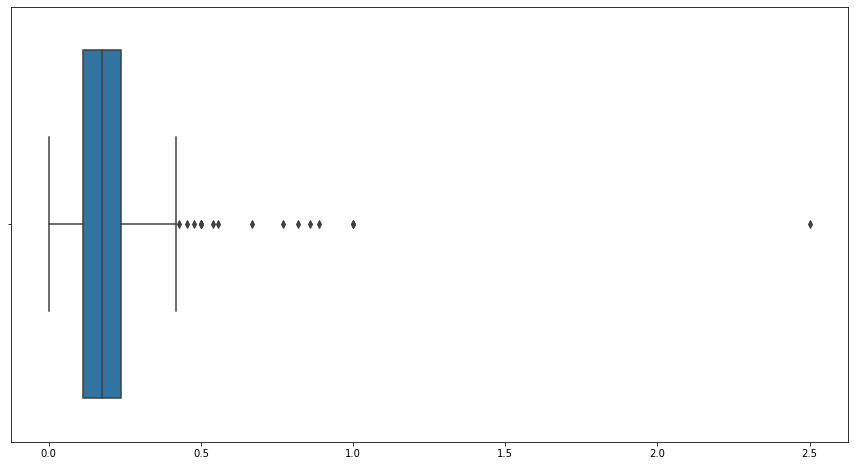

In [62]:
# Deel vars op elkaar en maak boxplot om te kijken wat uitschieter is
box_terug_vs_zon = ts.teruglevering / ts.zonneschijn
sns.boxplot(x = box_terug_vs_zon)
plt.show()

In [63]:
ts[box_terug_vs_zon == 2.5]

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2020-10-15  5.0     4.0            5.0    93            2              0   

            som_neerslag  day_of_week day_of_week_name  day_of_month  month  \
2020-10-15             0            3         Thursday            15     10   

           month_name  season  
2020-10-15    October  Autumn

In [64]:
# https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot

# finding the 1st quartile
q1 = box_terug_vs_zon.quantile(0.25)
 
# finding the 3rd quartile
q3 = box_terug_vs_zon.quantile(0.75)
med = box_terug_vs_zon.median()
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(lower_bound, iqr, upper_bound)

-0.06914787607425102 0.12216374695676885 0.4195071117528244


In [65]:
# Alles onder de lower en boven de upper zijn outliers
filter_zon = (box_terug_vs_zon <= lower_bound) & (box_terug_vs_zon >= upper_bound)
ts['anomaly_box_zon'] = filter_zon
ts.head()

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2021-05-29  1.0     4.0           20.0   116           73              0   
2021-05-28  0.0     3.0           25.0   121          124              0   
2021-05-27  2.0     4.0            9.0   109           34             84   
2021-05-26  1.0    11.0           11.0   109           52             59   
2021-05-25  0.0     7.0           13.0   105           37             18   

            som_neerslag  day_of_week day_of_week_name  day_of_month  month  \
2021-05-29             0            5         Saturday            29      5   
2021-05-28             0            4           Friday            28      5   
2021-05-27            75            3         Thursday            27      5   
2021-05-26            61            2        Wednesday            26      5   
2021-05-25             8            1          Tuesday            25      5   

           month_name  season  anomaly_box_zon  
2021-05-29        May  Spring            False  
2021-05-28        May  Spring            False  
2021-05-27        May  Spring            False  
2021-05-26        May  Spring            False  
2021-05-25        May  Spring            False

##### 2.4.2.2 Teuglevering en temperatuur

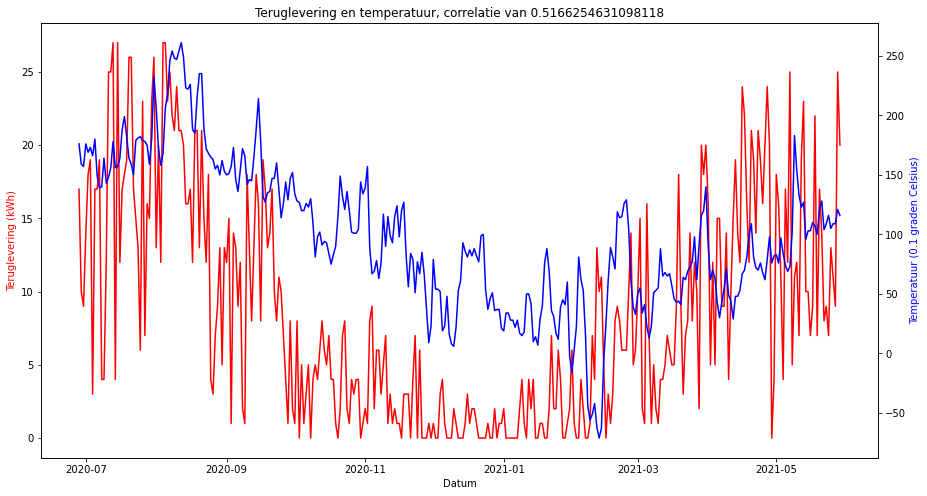

In [66]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ts.teruglevering, 'r')
ax2.plot(ts.temp, 'b')

ax1.set_xlabel('Datum')
ax1.set_ylabel('Teruglevering (kWh)', color='r')
ax2.set_ylabel('Temperatuur (0.1 graden Celsius)', color='b')

plt.title(f'Teruglevering en temperatuur, correlatie van {corr_temp}')
plt.show()

##### Outliers obv variabelen delen op elkaar

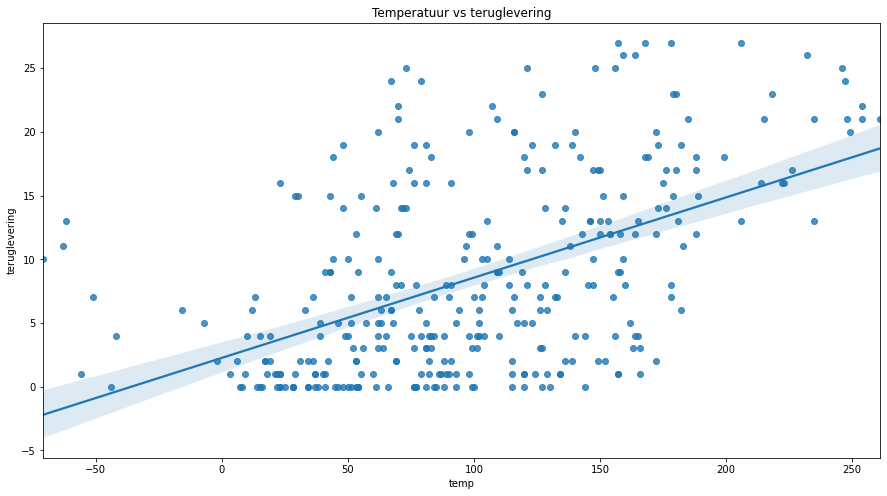

In [67]:
# Scatterplot
sns.regplot(data = ts, x = 'temp', y = 'teruglevering')
plt.title('Temperatuur vs teruglevering')
plt.show()

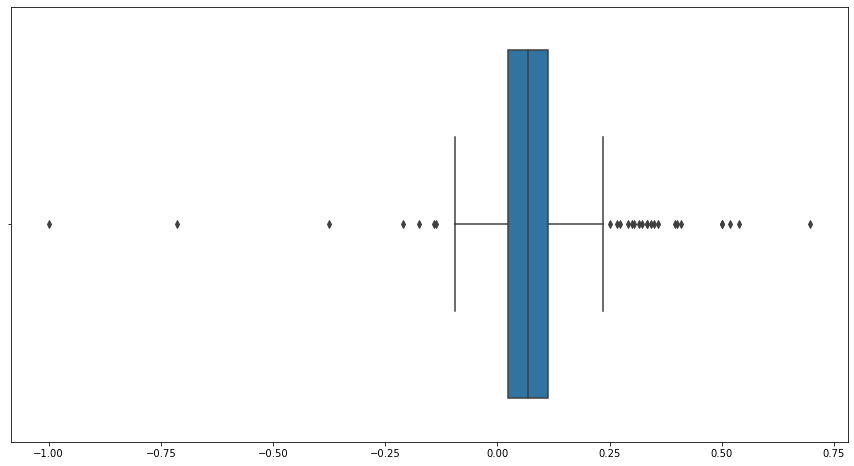

In [68]:
# Deel vars op elkaar en maak boxplot om te kijken wat uitschieter is
box_terug_vs_temp = ts.teruglevering / ts.temp
sns.boxplot(x = box_terug_vs_temp)
plt.show()

In [69]:
# https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot

# finding the 1st quartile
q1 = box_terug_vs_temp.quantile(0.25)
 
# finding the 3rd quartile
q3 = box_terug_vs_temp.quantile(0.75)
med = box_terug_vs_temp.median()
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(lower_bound, iqr, upper_bound)

-0.1115298891586537 0.08995216184902849 0.24827875823746026


In [70]:
# Alles onder de lower en boven de upper zijn outliers
filter_zon = (box_terug_vs_temp <= lower_bound) & (box_terug_vs_temp >= upper_bound)
ts['anomaly_box_temp'] = filter_zon
ts.head()

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2021-05-29  1.0     4.0           20.0   116           73              0   
2021-05-28  0.0     3.0           25.0   121          124              0   
2021-05-27  2.0     4.0            9.0   109           34             84   
2021-05-26  1.0    11.0           11.0   109           52             59   
2021-05-25  0.0     7.0           13.0   105           37             18   

            som_neerslag  day_of_week day_of_week_name  day_of_month  month  \
2021-05-29             0            5         Saturday            29      5   
2021-05-28             0            4           Friday            28      5   
2021-05-27            75            3         Thursday            27      5   
2021-05-26            61            2        Wednesday            26      5   
2021-05-25             8            1          Tuesday            25      5   

           month_name  season  anomaly_box_zon  anomaly_box_temp  
2021-05-29        May  Spring            False             False  
2021-05-28        May  Spring            False             False  
2021-05-27        May  Spring            False             False  
2021-05-26        May  Spring            False             False  
2021-05-25        May  Spring            False             False

Er is te zien dat zonneschijn en teruglevering bijna op elkaar zitten; de teruglevering is door zonnepanelen, dus dat is logisch. Ook hebben temperatuur en teruglevering een verglijkbare richting; ook logisch, want wanneer de zon schijnt is het (vaak) warm.

**Te verklaren variabele: Teruglevering op basis van zonnepanelen**

Extra variabelen ARIMA model:
- Zonneschijn (0.1 uur)
- Temperatuur (0.1 graden Celsius)

## 3 Outliers

Outlier detectie wordt gedaan obv Isolation Forest (IF). Outlier detectie op basis van seasonal decompose is niet mogelijk omdat de data minder dan twee jaar bevat, en dus kan seasonal decompose het seizoen niet herkennen.

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
# Kolommen die in het model worden verwerkt
cols_model = ['teruglevering', 'temp', 'zonneschijn']

In [73]:
# Data schalen
scaler = StandardScaler()
np_scaled = scaler.fit_transform(ts[cols_model])
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']] = np_scaled
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].head()

teruglevering_sc   temp_sc  zonneschijn_sc
2021-05-29          1.526239  0.274087        0.649640
2021-05-28          2.189649  0.354985        1.939885
2021-05-27          0.066736  0.160831       -0.337018
2021-05-26          0.332100  0.160831        0.118363
2021-05-25          0.597464  0.096114       -0.261121

In [74]:
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].describe()

teruglevering_sc       temp_sc  zonneschijn_sc
count      3.360000e+02  3.360000e+02    3.360000e+02
mean      -2.861468e-16  8.921435e-17    2.180795e-16
std        1.001491e+00  1.001491e+00    1.001491e+00
min       -1.127403e+00 -2.751468e+00   -1.197181e+00
25%       -8.620385e-01 -7.290378e-01   -9.188927e-01
50%       -1.986282e-01 -9.803969e-02   -1.599253e-01
75%        7.301462e-01  7.473360e-01    6.749389e-01
max        2.455013e+00  2.620106e+00    2.445863e+00

### 3.1 Isolation forest

- Anomaly = -1

Isolation forest wordt gemaakt obv de drie variabelen teruglevering, temperatuur en zonneschijn.

**Voordelen:**
1. Er kunnen net zo veel variabelen worden toegevoegd als je wil om zo een meer geavanceerd model te creeëren.
2. Als het model getraind is kan het ook toegepast worden op nieuwe data.

**Nadelen:**
1. Zelf de hoeveelheid outliers kiezen. Een IF zal dus **altijd** outliers vinden, ookal zijn er in de werkelijkheid geen outliers. Belangrijk is dus om het resultaat goed te bekijken.
2. Aan het begin van het leren kiest het waarschijnlijk punten die geen outliers zijn, omdat hij nog weinig data heeft gehad om op te leren.

Omdat er verschillende modellen worden gemaakt, worden er verschillende outliers gedefinieerd op basis van de variabelen die gebruikt worden in die modellen. Het eerste model wat gemaakt wordt is een model zonder extra regressors, wat betekent dat dat model alleen data kan gebruiken waar outliers vervangen zijn op basis van een isolation forest op basis van alléén teruglevering. Het tweede model heeft zonneschijn als extra regressor, wat betekent dat de outliers in dat model gebaseerd moeten zijn op teruglevering en zonneschijn. Het laatste model gebruikt zonneschijn en temperatuur, dus zijn de outliers voor dat model gedefinieerd op basis van teruglevering, zonneschijn en temperatuur.

In [75]:
from sklearn.ensemble import IsolationForest

In [76]:
outliers_fraction = float(.05) # 5% van de data wordt gedefinieerd als outlier

**Uitwerking waarom 5% als outlier**

#### 3.1.1 Isolation forest op basis van teruglevering

In [77]:
# Initialiseer en fit model
model_if_1 =  IsolationForest(contamination = outliers_fraction)
model_if_1.fit(ts[['teruglevering_sc']])

IsolationForest(contamination=0.05)

In [78]:
# Predict outliers
ts['anom_if_1'] = model_if_1.predict(ts[['teruglevering_sc']])
ts[['teruglevering_sc', 'anom_if_1']].head()

teruglevering_sc  anom_if_1
2021-05-29          1.526239          1
2021-05-28          2.189649         -1
2021-05-27          0.066736          1
2021-05-26          0.332100          1
2021-05-25          0.597464          1

In [79]:
ts.value_counts('anom_if_1')

anom_if_1
 1    321
-1     15
dtype: int64

#### 3.1.2 Isolation forest met teruglevering en zonneschijn

In [80]:
# Initialiseer en fit model
model_if_2 =  IsolationForest(contamination = outliers_fraction)
model_if_2.fit(ts[['teruglevering_sc', 'zonneschijn_sc']])

IsolationForest(contamination=0.05)

In [81]:
# Predict outliers
ts['anom_if_2'] = model_if_2.predict(ts[['teruglevering_sc', 'zonneschijn_sc']])
ts[['teruglevering_sc', 'zonneschijn_sc', 'anom_if_2']].head()

teruglevering_sc  zonneschijn_sc  anom_if_2
2021-05-29          1.526239        0.649640          1
2021-05-28          2.189649        1.939885          1
2021-05-27          0.066736       -0.337018          1
2021-05-26          0.332100        0.118363          1
2021-05-25          0.597464       -0.261121          1

In [82]:
ts.value_counts('anom_if_2')

anom_if_2
 1    319
-1     17
dtype: int64

#### 3.1.3 Isolation forest met teruglevering, zonneschijn en temperatuur

In [83]:
cols_model_scaled = ['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']

In [84]:
# Initialiseer en fit model
model_if_3 =  IsolationForest(contamination = outliers_fraction)
model_if_3.fit(ts[cols_model_scaled])

IsolationForest(contamination=0.05)

In [85]:
# Predict outliers
ts['anom_if_3'] = model_if_3.predict(ts[cols_model_scaled])
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc', 'anom_if_3']].head()

teruglevering_sc   temp_sc  zonneschijn_sc  anom_if_3
2021-05-29          1.526239  0.274087        0.649640          1
2021-05-28          2.189649  0.354985        1.939885          1
2021-05-27          0.066736  0.160831       -0.337018          1
2021-05-26          0.332100  0.160831        0.118363          1
2021-05-25          0.597464  0.096114       -0.261121          1

In [86]:
ts.value_counts('anom_if_3')

anom_if_3
 1    319
-1     17
dtype: int64

#### 3.1.4 Visualiseer resultaat

In [87]:
def plot_anom_result(ts, cols, anom_col, ax):
    """
    Returned plot met timeseries en anomalies aangekaart
    
    ts: dataframe
    cols: str, kolomnamen waarop anomalies gebaseerd zijn
    anom_col: str, kolomnaam waarin staat aangegeven welke punten anomalies zijn
    ax: ax, waarin geplot moet worden
    """
    
    # Aparte ts voor anomalies
    ts_anom = ts[ts[anom_col] == -1]
    # Plot ts
    ts[cols].plot(ax = ax)
    # Hightlight anomalies
    for col in cols:
        ax.scatter(ts_anom.index,
                   ts_anom[col],
                   c = 'r',
                   label = 'Anomaly')

    ax.legend().remove()

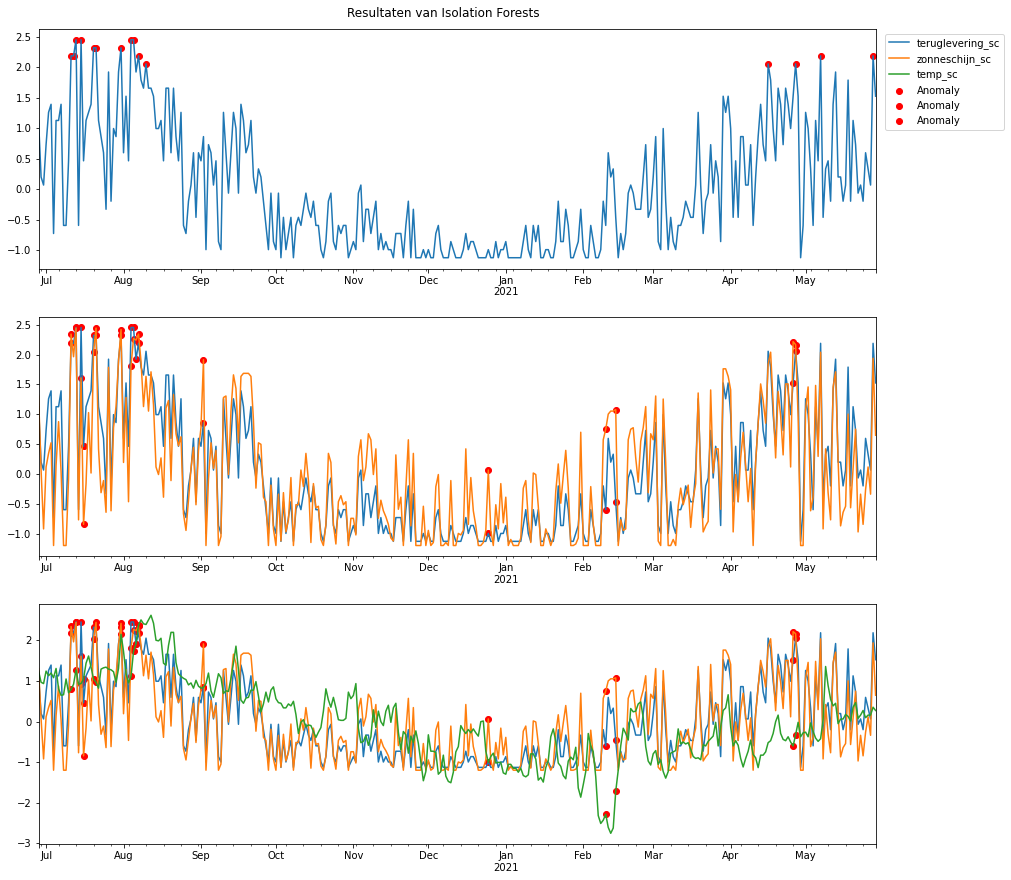

In [88]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))

plot_anom_result(ts, ['teruglevering_sc'], 'anom_if_1', ax[0])
plot_anom_result(ts, ['teruglevering_sc', 'zonneschijn_sc'], 'anom_if_2', ax[1])
plot_anom_result(ts, ['teruglevering_sc', 'zonneschijn_sc', 'temp_sc'], 'anom_if_2', ax[2])
plt.legend(bbox_to_anchor=(1.16, 3.4))
fig.suptitle('Resultaten van Isolation Forests', y = 0.9)
plt.show()

In alle plots is te zien dat aan het begin een aantal hoge waarden gedefinieerd zijn als outliers, maar dat deze waarden van teruglevering samenvallen met zonneschijn. Waarschijnlijk is dit omdat een IF aan het begin te snel outliers definieert omdat er getraind is op een klein deel van de data, en zullen deze punten dus niet veranderd worden. Verwachting is dus ook dat een toevoeging van zonneschijn als extra regressor een significante verbetering brengt in het model, omdat die hoge waarden van teruglevering samengaan met hoge waarden van zonneschijn. In eerste instantie zou men misschien denken dat er  een aantal onverwachte lage punten niet als outlier zijn gedefinieerd in de eerste plot, zoals in september 2020 en mei 2021 waar veel fluctuatie plaatsvindt. De IF ziet dit niet als outliers omdat deze fluctuatie vaker plaatsvindt, en in de tweede plots is ook te zien dat de fluctuatie ook plaatsvindt bij zonneschijn. Dit onderbouwt nogmaals de verwachting dat het model met zonneschijn als extra regressor een betere voorspelling geeft.

Er zijn ook punten waar teruglevering en zonneschijn verder uit elkaar liggen, op de helft van juli heeft zonneschijn bijvoorbeeld een waarde van -1 terwijl teruglevering een waarde van 0.5 heeft. De punten eromheen liggen ook verder uit elkaar. Waarschijnlijk is dit omdat de bewoners niet thuis (op vakantie) waren en dus geen electriciteit verbruikten, waardoor de teruglevering hoger is. Zulke punten zijn begin maart ook te zien. Het zou mooi zijn om een variabele te hebben die aangeeft wanneer bewoners niet thuis waren, dit zou het model kunnen verbeteren. Helaas is dit niet beschikbaar. Dit zou wel gemodelleerd kunnen worden met behulp van energieverbruik en teruglevering; wanneer het energieverbruik lager is en de teruglevering hoger is zijn de bewoners waarschijnlijk op vakantie. Bijvoorbeeld met unsupervised learning en twee clusters, waarbij 0 = niet thuis en 1 = wel thuis. **Gaan we dat doen?**

In de wintermaanden is te zien dat de zonneschijn vaak hoger ligt dan de teruglevering **In de wintermaanden wordt over het algemeen meer energie verbruikt, door dat men bijvoorbeeld hun huis wilt op warmen. Doordat er meer energie verbruikt wordt, kan er dus minder energie teruggeleverd worden. nog even mooie beredenering schrijven**

Bij de modellen waar outliers zijn gedefinieerd op basis van meerdere variabelen (tweede en derde plot) is te zien dat wanneer de waarden van de variabelen verder uit elkaar liggen de punten als outliers worden gedefinieerd. De punten zijn vaak hetzelfde. 

Outliers worden geinterpoleerd. Met de hand worden de punten aan het begin van de tijdreeks die geen outliers zijn eruit gehaald en niet veranderd. Voor het eerste IF is dat alles vóór september 2020. Voor het tweede IF wordt zonneschijn geinterpoleerd en bij het derde IF worden zonneschijn en temperatuur geinterpoleerd.

##### 3.1.5.1 Interpolatie model 1

In [89]:
test = ts[ts['anom_if_1'] == -1]
test.tail(5)

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
2020-07-20  0.0     2.0           26.0   164          128              0   
2020-07-15  0.0     1.0           27.0   157          111              4   
2020-07-13  0.0     1.0           27.0   178          144              0   
2020-07-12  0.0    10.0           25.0   156          125              7   
2020-07-11  1.0     2.0           25.0   148          140              0   

            som_neerslag  day_of_week day_of_week_name  day_of_month  ...  \
2020-07-20            -1            0           Monday            20  ...   
2020-07-15             2            2        Wednesday            15  ...   
2020-07-13             0            0           Monday            13  ...   
2020-07-12             9            6           Sunday            12  ...   
2020-07-11             0            5         Saturday            11  ...   

            month_name  season anomaly_box_zon  anomaly_box_temp  \
2020-07-20        July  Summer           False             False   
2020-07-15        July  Summer           False             False   
2020-07-13        July  Summer           False             False   
2020-07-12        July  Summer           False             False   
2020-07-11        July  Summer           False             False   

            teruglevering_sc   temp_sc  zonneschijn_sc  anom_if_1  anom_if_2  \
2020-07-20          2.322331  1.050700        2.041080         -1         -1   
2020-07-15          2.455013  0.937444        1.610999         -1         -1   
2020-07-13          2.455013  1.277213        2.445863         -1         -1   
2020-07-12          2.189649  0.921265        1.965183         -1          1   
2020-07-11          2.189649  0.791829        2.344667         -1         -1   

            anom_if_3  
2020-07-20          1  
2020-07-15          1  
2020-07-13         -1  
2020-07-12          1  
2020-07-11          1  

[5 rows x 21 columns]

In [90]:
# Alleen de laatste paar outliers 
ts_int_1 = ts[ts['anom_if_1'] == -1].index[8:].to_list()

# Veranderen van index, dit maakt de volgendes stap eenvoudiger
ts.reset_index(inplace = True)

# Het vervangen van de gemeten waardes door Na-Waardes voor de uitschieters, de rest mag blijven staan
ts['teruglevering_int_1'] = ts.apply(lambda x: np.nan if (x['index'] in ts_int_1) and (x.anom_if_1 == -1) else x.teruglevering, axis = 1)

# Terugzetten van de index
ts.set_index('index', drop=True, inplace=True)

# Interpolatie
ts['teruglevering_int_1'] = ts['teruglevering_int_1'].interpolate()

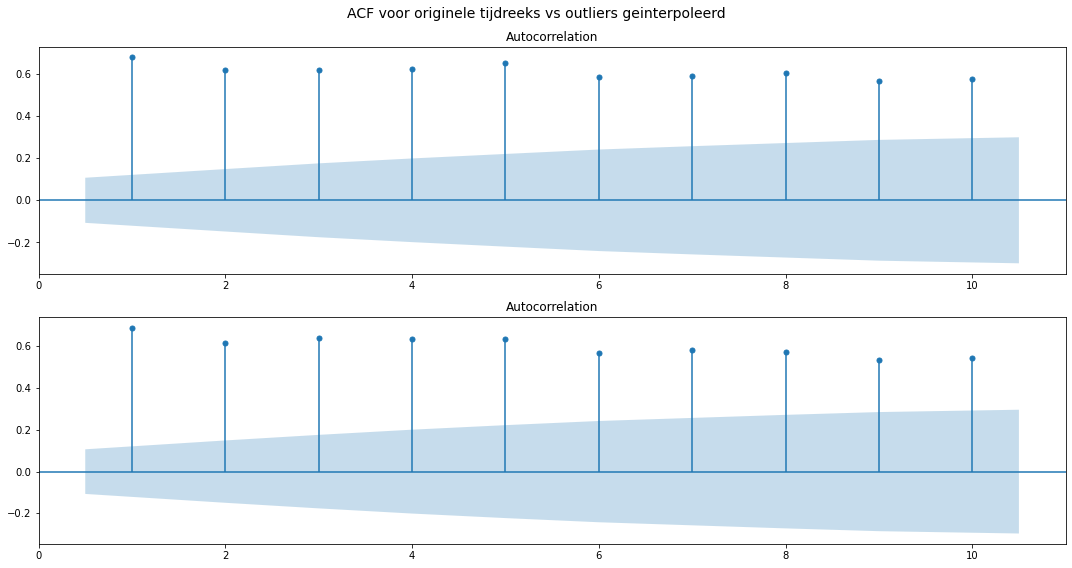

In [91]:
# ACF voor originele en bewerkte tijdreeks
fig, ax = plt.subplots(2,1)

plot_acf(ts['teruglevering'], lags = 10, zero = False, ax = ax[0])
plot_acf(ts['teruglevering_int_1'], lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF voor originele tijdreeks vs outliers geinterpoleerd', size = 14)
plt.tight_layout()
plt.show()

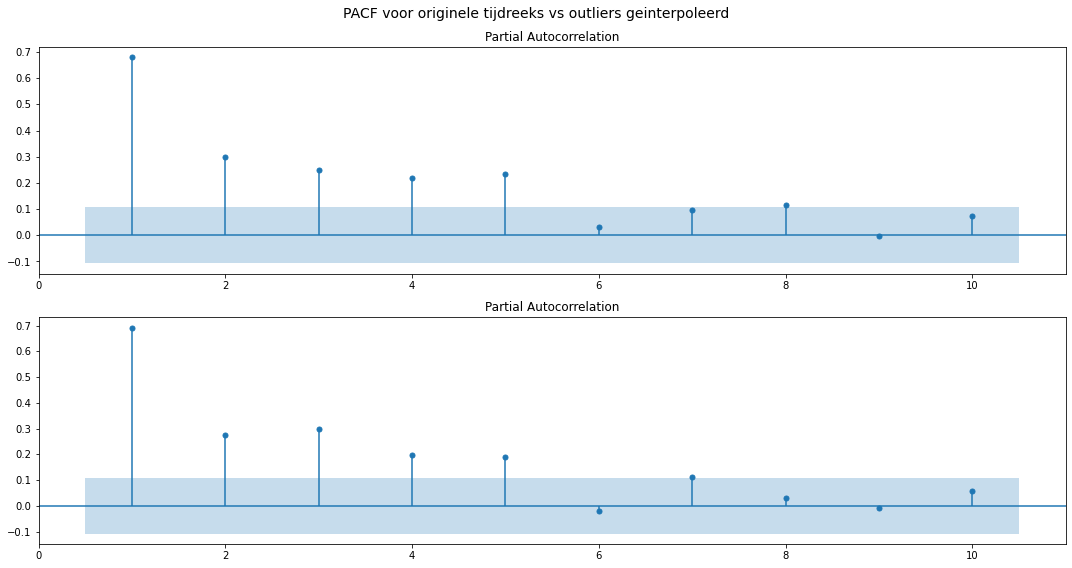

In [92]:
# PACF voor originele en bewerkte tijdreeks
fig, ax = plt.subplots(2,1)

plot_pacf(ts['teruglevering'], lags = 10, zero = False, ax = ax[0])
plot_pacf(ts['teruglevering_int_1'], lags = 10, zero = False, ax = ax[1])
fig.suptitle('PACF voor originele tijdreeks vs outliers geinterpoleerd', size = 14)
plt.tight_layout()
plt.show()

Uit de isolation forest van het eerste model volgen meerder outliers, er is voor gekozen om alleen de outliers aan de rechterkant te interpoleren. Vanwege het feit dat het model aan het begin van de tijdreeks nog aan het leren is en hierdoor meer datapunten als outliers ziet dan aan het eind van de tijdreeks. Met dit gegeven en de visualisatie van de outliers is besloten om de 5 meest rechter outliers te vervangen door middel van interpolatie.

Vervolgens is voor zowel de orginele en bewerkte tijdreeks een acf en pacf plot gemaakt. Er is te zien dat er bij de ACF geen opmerkelijke veranderingen zijn. Bij de PACF wel; in de originele ts is lag 7 niet significant maar lag 8 wel, terwijl het in de bewerkte tijdreeks andersom is. Lag 6 is in de originele tijdreeks positief, maar in de bewerkte tijdreeks negatief. 

De verschillen zijn niet heel groot. Net zoals lag 7 in ded orignele tijdreeks ligt lag 8 in de bewerkte tijdreeks maar net buiten het betrouwbaarheidsinterval, en de correlatie van lag 6 is niet significant. Om deze reden is er dus voor gekozen te werken met de bewerkte tijdreeks **voor het eerste model** omdat hier geen extra regressors (zonneschijn of temperatuur) aan toegevoegd worden. Waar zonneschijn wordt toegevoegd als extra regressor wordt in eerste instantie gewerkt met de originele tijdreeks, omdat de correlatie tussen die twee erg hoor is.

## 4 Modellen
De te verklaren variabele is teruglevering. Modellen worden gemaakt op geschaalde data.

1. Als eerste worden er Fourier terms toegevoegd om het seizoenscomponent te modelleren. Dit is nodig omdat de dataset korter is dan twee jaar, en dus kan ARIMA het seizoen niet herkennen.
2. Tweede stap is om de extra voorspellende variabele zonneschijnuren toe te voegen en te bekijken of het model zo verbeterd is. Deze variabele wordt als eerste gekozen omdat die de hoogste correlatie heeft met teruglevering.
3. De laatste variabele die wordt toegevoegd is de temperatuur. Weer wordt er gekeken of dit verbetering opleverd.

Er wordt een dataset gemaakt met daarin de modellen en hun AIC- en MAPE-waarden. Het beste model wordt gekozen op basis van deze waarden, en met dat model wordt de voorspelling van een week gemaakt.

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [94]:
cols_model = ['teruglevering', 'teruglevering_int_1', 'temp', 'zonneschijn']
cols_model

['teruglevering', 'teruglevering_int_1', 'temp', 'zonneschijn']

In [95]:
# Alles opnieuw schalen inclusief bewerkte tijdreeks
scaler = StandardScaler()
np_scaled = scaler.fit_transform(ts[cols_model])
ts[['teruglevering_sc', 'teruglevering_int_1_sc', 'temp_sc', 'zonneschijn_sc']] = np_scaled
ts[['teruglevering_sc', 'teruglevering_int_1_sc', 'temp_sc', 'zonneschijn_sc']].head(3)

teruglevering_sc  teruglevering_int_1_sc   temp_sc  zonneschijn_sc
index                                                                         
2021-05-29          1.526239                1.648142  0.274087        0.649640
2021-05-28          2.189649                2.347177  0.354985        1.939885
2021-05-27          0.066736                0.110264  0.160831       -0.337018

In [96]:
ts[['teruglevering_sc', 'teruglevering_int_1_sc', 'temp_sc', 'zonneschijn_sc']].describe()

teruglevering_sc  teruglevering_int_1_sc       temp_sc  zonneschijn_sc
count      3.360000e+02            3.360000e+02  3.360000e+02    3.360000e+02
mean      -2.861468e-16           -1.685160e-16  8.921435e-17    2.180795e-16
std        1.001491e+00            1.001491e+00  1.001491e+00    1.001491e+00
min       -1.127403e+00           -1.147999e+00 -2.751468e+00   -1.197181e+00
25%       -8.620385e-01           -8.683846e-01 -7.290378e-01   -9.188927e-01
50%       -1.986282e-01           -2.392531e-01 -9.803969e-02   -1.599253e-01
75%        7.301462e-01            8.092995e-01  7.473360e-01    6.749389e-01
max        2.455013e+00            2.626791e+00  2.620106e+00    2.445863e+00

In [97]:
# Maak nieuwe dataset waarin alleen benodigde data staat
ts_model = ts[['teruglevering', 'teruglevering_int_1', 
               'teruglevering_sc', 'teruglevering_int_1_sc', 'temp_sc', 'zonneschijn_sc']].copy()
ts_model.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-05-29           20.0                 20.0          1.526239   
2021-05-28           25.0                 25.0          2.189649   
2021-05-27            9.0                  9.0          0.066736   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  
index                                                         
2021-05-29                1.648142  0.274087        0.649640  
2021-05-28                2.347177  0.354985        1.939885  
2021-05-27                0.110264  0.160831       -0.337018

In [98]:
print(f'Eerste datum in dataset: {ts_model.index.min()}')
print(f'Laatste datum in dataset: {ts_model.index.max()}')
print(f'Lengte dataset: {len(ts_model)}')

Eerste datum in dataset: 2020-06-28 00:00:00
Laatste datum in dataset: 2021-05-29 00:00:00
Lengte dataset: 336


We willen 7 dagen (één week) voorspellen en de dataset bevat 336 dagen. Op basis van deze informatie kiezen we voor een test-set van 35 dagen (vijf weken). Dit is minder dat 10% en is ongeveer een maand.

In [99]:
date_min = ts_model.index.min()
date_max = ts_model.index.max()
len_test = timedelta(days = 35)

De test-set moet 35 dagen zijn, dus de train-set eindigt één dag eerder.

In [100]:
ts_train = ts_model.loc[ts_model.index.max() - len_test - timedelta(days = 1):].copy()
ts_test = ts_model.loc[:ts_model.index.max() - len_test].copy()
ts_train.head()

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   
2021-04-20           21.0                 21.0          1.658921   
2021-04-19           12.0                 12.0          0.464782   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  
index                                                         
2021-04-23                1.787949 -0.470167        1.509803  
2021-04-22                0.809299 -0.437808        0.320754  
2021-04-21                1.508334 -0.292193        0.978526  
2021-04-20                1.787949  0.160831        1.383308  
2021-04-19                0.529685 -0.000963        0.270156

In [101]:
ts_test.tail()

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-28           20.0                 20.0          1.526239   
2021-04-27           24.0                 24.0          2.056967   
2021-04-26           20.0                 20.0          1.526239   
2021-04-25           16.0                 16.0          0.995510   
2021-04-24           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  
index                                                         
2021-04-28                1.648142 -0.017143        0.953227  
2021-04-27                2.207370 -0.324552        2.167575  
2021-04-26                1.648142 -0.599602        2.218173  
2021-04-25                1.088913 -0.502526        0.118363  
2021-04-24                1.508334 -0.373090        1.509803

Train-set eindigt op 23 april, test-set begint op 24 april.

### 4.1 Seizoenscomponent modelleren (Fourier Terms)
Omdat de dataset korter is dan twee jaar, kan een ARIMA-model niet zelf het jaarlijkse seizoenspatroon herkennen. Om dit op te lossen worden er Fourier terms gebruikt om het seizoenscomponent te modelleren.

In [102]:
# Initialieer nieuwe dataframe waarbij index dezelfde data heeft als teruglevering om Fourier Terms in te zetten
df_exog = pd.DataFrame({'date': ts_model.index}) 
df_exog = df_exog.set_index('date')
df_exog.head(3)

Empty DataFrame
Columns: []
Index: [2021-05-29 00:00:00, 2021-05-28 00:00:00, 2021-05-27 00:00:00]

In [103]:
# Dictionairy waarin resultaten van auto_arima worden opgeslagen
dict_aa = {}

# Er wordt een loop doorlopen waarbij 1 tot en met 4 fourier terms worden toegevoegd aan het model
for k in np.arange(2, 10, 2):
    
    # Maak fourier terms aan
    df_exog[f'sin365_{int(k/2)}'] = np.sin(k * np.pi * df_exog.index.dayofyear / 365.25)
    df_exog[f'cos365_{int(k/2)}'] = np.cos(k * np.pi * df_exog.index.dayofyear / 365.25)
    
    # Train test split voor fourier terms
    exog_train = df_exog.iloc[-len(ts_train):]
    exog_test = df_exog.iloc[:len(ts_test)]
    
    # Auto arima doen
    res = pm.auto_arima(ts_train['teruglevering_int_1_sc'], exogenous = exog_train,
                        d = 1, # Één keer differentiëren
                        start_p = 0, max_p = 2, # p is waarschijnlijk 4, dus we zoeken tussen 3 en 5
                        start_q = 1, max_q = 4, # q is waarchijnlik 1, dus we zoeken tussen 0 en 3
                        information_criterion = 'aic',# Beste model wordt gekozen obv aic
                        trace = True, error_action = 'ignore', stepwise = True
                       )
    # Beste model in dictionairy gooien
    dict_aa[k/2] = [res.order, res.aic()]
    print()
    
print('\nResultaten:')   
print(dict_aa)

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=540.841, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=649.851, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=601.217, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=647.867, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=539.546, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=541.033, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=532.481, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=539.117, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=533.992, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=534.017, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=540.531, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=531.104, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=537.930, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=538.400, 

De laagste AIC is bij p = 1, d = 1 en q = 2 met 1 Fourier term. Er wordt dus gekozen voor **één** Fourier Term.

In [104]:
# Kolommen waar FT in staan
aantal_fourier = 1
fourier_cols = df_exog.columns[0:2*aantal_fourier]
fourier_cols

Index(['sin365_1', 'cos365_1'], dtype='object')

In [105]:
# Voeg de fourier terms toe aan ts_model
ts_model[fourier_cols] = df_exog[fourier_cols].copy()

# Opnieuw train-test split doen want fourier terms staan er nu niet in 
ts_train = ts_model.loc[ts_model.index.max() - len_test - timedelta(days = 1):].copy()
ts_test = ts_model.loc[:ts_model.index.max() - len_test].copy()
ts_train.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803  0.931210   
2021-04-22                0.809299 -0.437808        0.320754  0.937342   
2021-04-21                1.508334 -0.292193        0.978526  0.943196   

            cos365_1  
index                 
2021-04-23 -0.364483  
2021-04-22 -0.348411  
2021-04-21 -0.332235

In [106]:
# Auto-ARIMA met FT
res_fourier = pm.auto_arima(ts_train['teruglevering_int_1_sc'], 
                        d = 1,
                        start_p = 0, max_p = 2,
                        start_q = 2, max_q = 3,
                        exogenous = ts_train[fourier_cols],
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
print(res_fourier.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=539.117, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=649.851, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=601.217, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=540.841, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=647.867, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=532.481, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=539.546, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=533.992, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=534.017, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=540.531, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=541.033, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=531.104, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=537.930, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=538.400, 

P-waarde van sin is erg hoog, de rest is wel significant. **Meer uitleg wat alles betekent**

In [107]:
# Maak df met daarin alleen fourier terms vermenigvuldigd met hun coeff zodat ze gevisualiseerd kunnen worden
df_fourier = pd.DataFrame()

# Krijg coeff
coeff_S1 = res_fourier.params()[1]
coeff_C1 = res_fourier.params()[2]

# Vermenigvuldig coeff met bijbehorende term
df_fourier['S1'] = coeff_S1 * ts_model[fourier_cols[0]]
df_fourier['C1'] = coeff_C1 * ts_model[fourier_cols[1]]

# Tel terms met dezelfde periode bij elkaar op
df_fourier['Fourier_1'] = df_fourier['S1'] + df_fourier['C1']

df_fourier.head(3)

S1        C1  Fourier_1
index                                    
2021-05-29 -0.779546  0.715142  -0.064405
2021-05-28 -0.799968  0.707004  -0.092964
2021-05-27 -0.820154  0.698657  -0.121497

In [108]:
# fig, ax = plt.subplots(2,1)

# df_fourier[['Fourier_1', 'Fourier_2']].plot(ax = ax[0])
# ax[0].set_title('De Fourier terms die het jaarlijkse seizoenscomponent modelleren')

# df_fourier['Fourier_total'].plot(ax = ax[1], label = 'Seizoen door Fourier terms')
# ts['teruglevering_int_1'].plot(ax = ax[1], label = 'Teruglevering meting')
# ax[1].set_title('Gemodelleerd seizoenscomponent door Fourier terms')
# ax[1].legend()

# fig.suptitle('Resultaten seizoenscomponent met behulp van Fourier terms', size = 14)
# plt.tight_layout()
# plt.show()

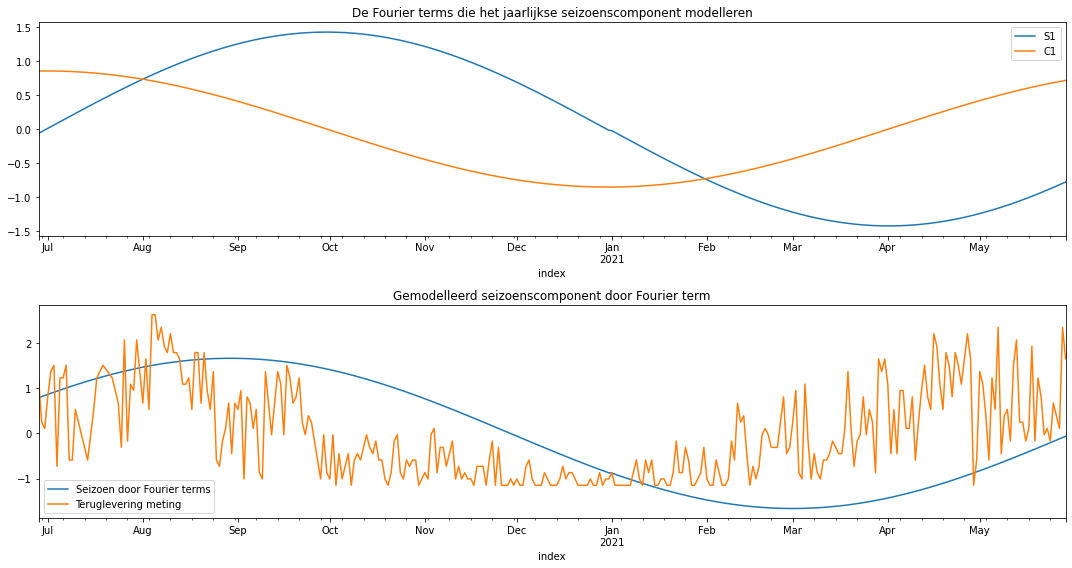

In [109]:
fig, ax = plt.subplots(2,1)

df_fourier[['S1', 'C1']].plot(ax = ax[0])
ax[0].set_title('De Fourier terms die het jaarlijkse seizoenscomponent modelleren')

df_fourier['Fourier_1'].plot(label = 'Seizoen door Fourier terms')
ts['teruglevering_int_1_sc'].plot(label = 'Teruglevering meting')
ax[1].set_title('Gemodelleerd seizoenscomponent door Fourier term')
ax[1].legend()

plt.tight_layout()
plt.show()

De FT lijkt het seizoen redelijk te volgen; wat gelijk opvalt is dat het onder 0 gaat terwijl de teruglevering niet negatief kan zijn. Het minimum van de FT zou het liefst tussen december en januari vallen, maar nu valt het in maart. Dit model geeft waarschijnlijk geen hele goede voorspellingen op de test-set.

In [110]:
def rev_scale(scaler, ts, col_pred):
    """
    Returns de terug geschaalde voorspelling
    ts: dataframe, train of testset
    cols_pred: kolom waar de originele voorspelling in staat
    """
    rev = scaler.inverse_transform(ts[['teruglevering_sc', col_pred, 'temp_sc', 'zonneschijn_sc']])
    return rev.T[1]

In [111]:
ts_train['pred_fourier1'] = res_fourier.predict_in_sample(exogenous = ts_train[fourier_cols])
ts_train['pred_fourier1_rev'] = rev_scale(scaler, ts_train, 'pred_fourier1')
ts_train.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803  0.931210   
2021-04-22                0.809299 -0.437808        0.320754  0.937342   
2021-04-21                1.508334 -0.292193        0.978526  0.943196   

            cos365_1  pred_fourier1  pred_fourier1_rev  
index                                                   
2021-04-23 -0.364483       0.382342          10.946094  
2021-04-22 -0.348411       1.764127          20.829608  
2021-04-21 -0.332235       1.180099          16.652221

In [112]:
ts_test['pred_fourier1'] = res_fourier.predict(len(ts_test), exogenous = ts_test[fourier_cols])
ts_test['pred_fourier1_rev'] = rev_scale(scaler, ts_test, 'pred_fourier1')
ts_test.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-05-29           20.0                 20.0          1.526239   
2021-05-28           25.0                 25.0          2.189649   
2021-05-27            9.0                  9.0          0.066736   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-05-29                1.648142  0.274087        0.649640  0.546711   
2021-05-28                2.347177  0.354985        1.939885  0.561034   
2021-05-27                0.110264  0.160831       -0.337018  0.575190   

            cos365_1  pred_fourier1  pred_fourier1_rev  
index                                                   
2021-05-29 -0.837321       0.306240          10.401756  
2021-05-28 -0.827793       0.435789          11.328385  
2021-05-27 -0.818020       0.295711          10.326450

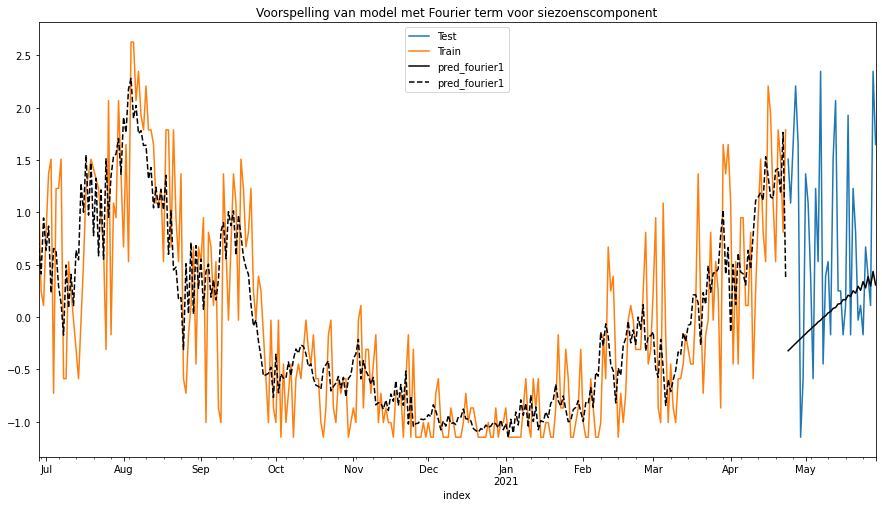

In [113]:
ax = ts_test['teruglevering_int_1_sc'].plot(label = 'Test') # Testset 
ts_train['teruglevering_int_1_sc'].plot(label = 'Train', ax = ax) # Train set
ts_test['pred_fourier1'].plot(color = 'k') # Voorspelling
ts_train['pred_fourier1'].plot(ax=ax, style='--', color='k', legend = False) # In sample pred voor train

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model met Fourier term voor siezoenscomponent')
plt.legend()
plt.show()

Voorspelling doet zoals verwacht het tegenovergestelde in de testset; de voorspelling stijgt maar over het algemeen doet de testset dat niet.

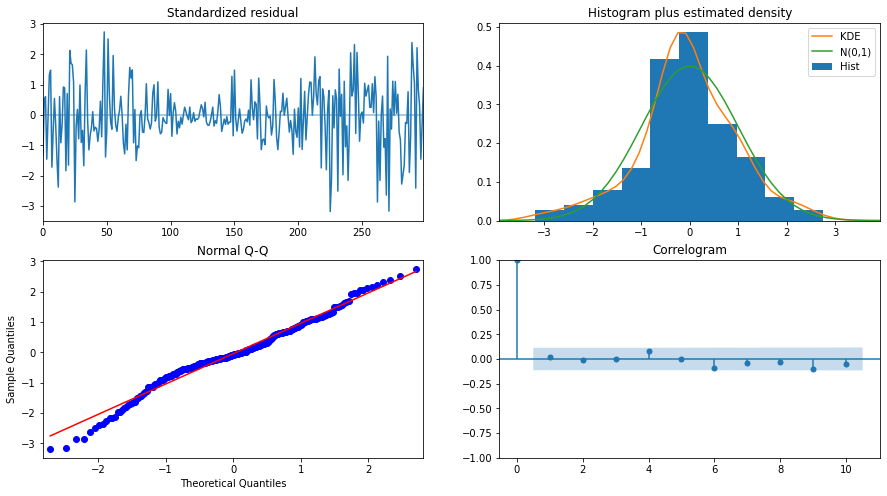

In [114]:
res_fourier.plot_diagnostics()
plt.show()

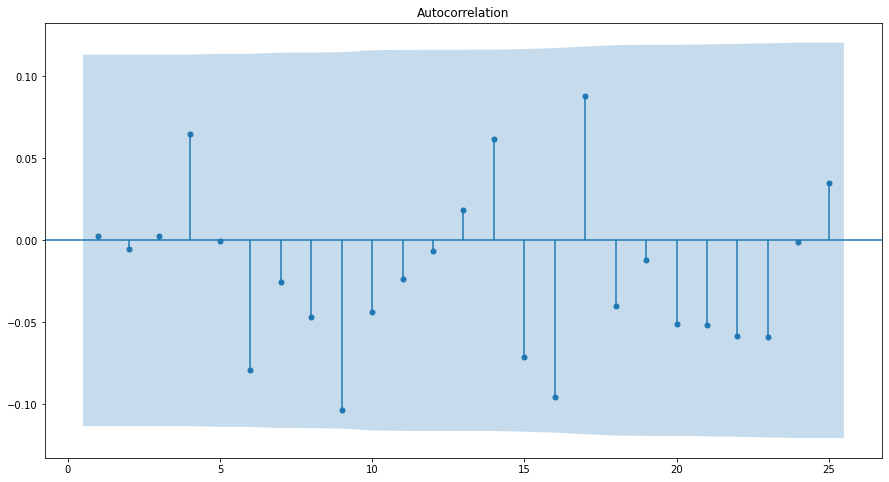

In [115]:
# Correlogram is een beetje onduidelijk dus nogmaals plotten
plot_acf(res_fourier.resid(), zero = False)
plt.show()

In [116]:
# Shapiro-Wilk voor residu
shap_fourier = shapiro(res_fourier.resid())
shap_pval_fourier = shap_fourier[0]
shap_pval_fourier

0.9803023934364319

Residu ziet er ook niet geweldig uit. Er is een patroon in te herkennen, maar volgt wel redelijk de normaalverdeling. Er is geen autocorrelatie in het residu.

In [117]:
mape_fourier1 = mean_absolute_percentage_error(ts_test['teruglevering_int_1'], ts_test['pred_fourier1_rev'])
mape_fourier1

<ipython-input-2-2cfd7997cc7c>:6: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((pred - actual) / actual)) * 100


inf

De werkelijke waarde van teruglevering kan 0 zijn, daarom is de MAPE oneindig. Er moet dus een andere metric gebruikt worden. We kiezen voor MAE. Dit is in principe hetzelfde als de MAPE alleen is de MAPE in **procenten** en de MAE is de **absolute error**.

In [118]:
mae_fourier1 = mean_absolute_error(ts_test['teruglevering_int_1'], ts_test['pred_fourier1_rev'])
mae_fourier1

6.531391122326459

In [119]:
# Dictionairy waarin MAPEs van alle modellen worden opgeslagen zodat ze aan het einde vergeleken kunnen worden
# Key is model, value is mape
dict_mae = {'Fourier1' : mae_fourier1}
dict_mae

{'Fourier1': 6.531391122326459}

In [120]:
ts['teruglevering'].describe()

count    336.000000
mean       8.497024
std        7.548054
min        0.000000
25%        2.000000
50%        7.000000
75%       14.000000
max       27.000000
Name: teruglevering, dtype: float64

Het model ziet er niet zo goed uit, dus misschien beter om voorspellende variabelen te gebruiken ipv seizoenscomponent te modelleren met Fourier terms. Zonneschijn is namelijk ook seizoensgebonden. Residu is wel normaal verdeeld (histogram, QQplot en shapiro-wilk toets). 

De mean absolute error is berekend om te bekijken hoe accuraat het model is met het voorspellen. Gekeken naar de spreiding van teruglevering is een MAE van 6.5 een hoge waarde, en is er dus zeker ruimte voor verbetering van het model.

### 4.2 Tweede model met zonneschijnuren als voorspellende variabele, zonder Fourier Terms

Zonneschijnuren heeft de hoogste correlatie met de teruglevering van zonnepanelen, daarom is dit de eerste variabele die we gebruiken als voorspellende variabele. In het volgende model wordt ook temperatuur toegevoegd, om te kijken of dit een verbetering geeft op de voorspelling. Hier wordt **niet** meer de tijdreeks gebruikt waar de outliers zijn geinterpoleerd.

#### 4.2.1 Het eerste model is gemaakt op basis van de ACF en PACF plots.

In [121]:
ts_train.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803  0.931210   
2021-04-22                0.809299 -0.437808        0.320754  0.937342   
2021-04-21                1.508334 -0.292193        0.978526  0.943196   

            cos365_1  pred_fourier1  pred_fourier1_rev  
index                                                   
2021-04-23 -0.364483       0.382342          10.946094  
2021-04-22 -0.348411       1.764127          20.829608  
2021-04-21 -0.332235       1.180099          16.652221

In [122]:
# Afgelezen uit ACF en PACF: p = 4, d = 1 en q = 0 (bij dataverkenning)
res_zon1 = SARIMAX(ts_train['teruglevering_sc'], 
                   order = (4,1,0),
                   exog = ts_train[['zonneschijn_sc']],
                   trend = None
                  ).fit()

res_zon1.summary()

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       teruglevering_sc   No. Observations:                  300
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 -42.938
Date:                Sat, 08 Jan 2022   AIC                             97.875
Time:                        13:23:20   BIC                            120.078
Sample:                             0   HQIC                           106.762
                                - 300                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
zonneschijn_sc     0.6352      0.017     37.267      0.000       0.602       0.669
ar.L1             -0.8477      0.060    -14.038      0.000      -0.966      -0.729
ar.L2             -0.6906      0.070     -9.814      0.000      -0.828      -0.553
ar.L3             -0.4309      0.061     -7.099      0.000      -0.550      -0.312
ar.L4             -0.1560      0.050     -3.093      0.002      -0.255      -0.057
sigma2             0.0778      0.005     15.015      0.000       0.068       0.088
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                25.49
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.32
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Meer informatie geven over wat er uit te lezen valt uit het model**

In [123]:
ts_train['pred_zon1'] = res_zon1.predict(steps = len(ts_train), exog = ts_train['zonneschijn_sc'])
ts_train['pred_zon1_rev'] = rev_scale(scaler, ts_train, 'pred_zon1')
ts_train.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803  0.931210   
2021-04-22                0.809299 -0.437808        0.320754  0.937342   
2021-04-21                1.508334 -0.292193        0.978526  0.943196   

            cos365_1  pred_fourier1  pred_fourier1_rev  pred_zon1  \
index                                                               
2021-04-23 -0.364483       0.382342          10.946094   0.959009   
2021-04-22 -0.348411       1.764127          20.829608   0.903650   
2021-04-21 -0.332235       1.180099          16.652221   1.233013   

            pred_zon1_rev  
index                      
2021-04-23      15.070833  
2021-04-22      14.674866  
2021-04-21      17.030705

In [124]:
pred_zon1 = res_zon1.forecast(steps = len(ts_test), index = ts_test.index,
                  exog = ts_test['zonneschijn_sc'])

ts_test['pred_zon1'] = pred_zon1
ts_test['pred_zon1_rev'] = rev_scale(scaler, ts_test, 'pred_zon1')
ts_test.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-05-29           20.0                 20.0          1.526239   
2021-05-28           25.0                 25.0          2.189649   
2021-05-27            9.0                  9.0          0.066736   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-05-29                1.648142  0.274087        0.649640  0.546711   
2021-05-28                2.347177  0.354985        1.939885  0.561034   
2021-05-27                0.110264  0.160831       -0.337018  0.575190   

            cos365_1  pred_fourier1  pred_fourier1_rev  pred_zon1  \
index                                                               
2021-05-29 -0.837321       0.306240          10.401756   0.993915   
2021-05-28 -0.827793       0.435789          11.328385   1.689077   
2021-05-27 -0.818020       0.295711          10.326450   0.168637   

            pred_zon1_rev  
index                      
2021-05-29      15.320499  
2021-05-28      20.292802  
2021-05-27       9.417525

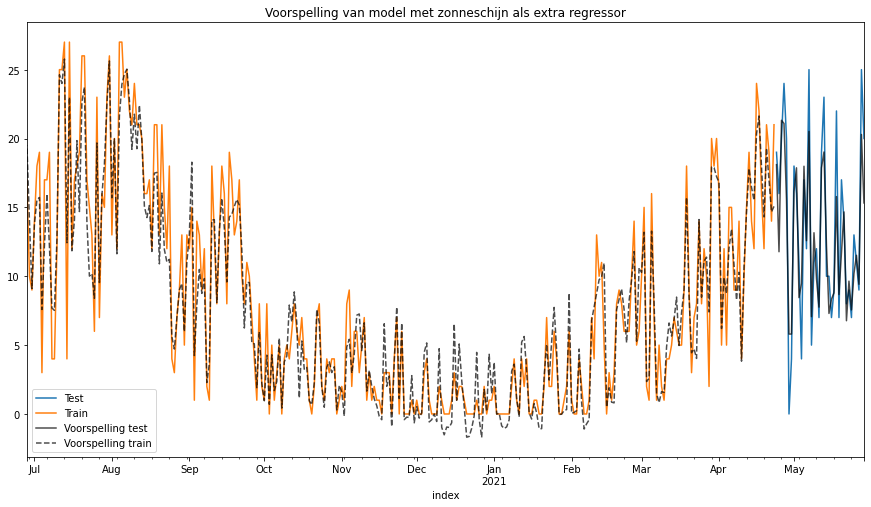

In [125]:
ax = ts_test['teruglevering'].plot(label = 'Test') # Testset 
ts_train['teruglevering'].plot(label = 'Train', ax = ax) # Train set

ts_test['pred_zon1_rev'].plot(ax=ax, color = 'k', alpha = 0.7,
                              label = 'Voorspelling test') # Voorspelling

ts_train['pred_zon1_rev'].plot(ax=ax, style='--', color='k', # In sample pred voor train
                           label = 'Voorspelling train', alpha = 0.7) 

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model met zonneschijn als extra regressor')
plt.legend()
plt.show()

Ziet er al veel beter uit dan het vorige model; Alleen tijdens de wintermaanden voorspelt 'ie te hoge waarden terwijl de voorspellingen in de zomermaanden juist te dicht bij elkaar liggen.

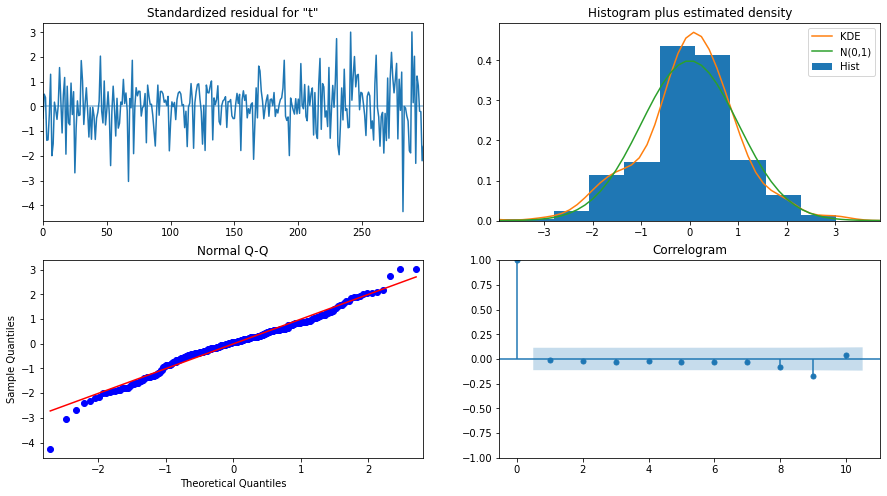

In [126]:
res_zon1.plot_diagnostics()
plt.show()

In [127]:
# Shapiro-Wilk voor residu
shap_zon1 = shapiro(res_zon1.resid)
shap_pval_zon1 = shap_zon1[0]
shap_pval_zon1

0.9804790019989014

In [128]:
mae_zon1 = mean_absolute_error(ts_test['teruglevering'], ts_test['pred_zon1_rev'])
dict_mae['Zon1'] = mae_zon1
dict_mae

{'Fourier1': 6.531391122326459, 'Zon1': 2.426574453369559}

Er is nogsteeds een patroon te herkennen in de residuen over de tijd, wat betekent dat het model verbeterd moet worden. Het is wel al verbeterd ten opzichte van het eerste model. Ook is er informatie nog niet verwerkt in het model, te zien aan de correlogram die nog significante correlatie heeft bij lag 9. Wel is het residu normaal verdeeld (histogram, QQplot en shapiro-wilk toets). Het model voorspelt ook negatief terwijl dat niet mogelijk moet zijn. 

Er is wel een grote verbetering in de MAE te zien; van 6.5 naar 2.4.

#### 4.2.2 Model obv auto arima
Is een model gemaakt obv auto-arima beter dan ons eigen model?

In [129]:
# Auto-ARIMA met X var
res_zon2 = pm.auto_arima(ts_train['teruglevering_sc'], 
                        d = 1,
                        start_p = 4, max_p = 6,
                        start_q = 0, max_q = 1,
                        exogenous = ts_train[['zonneschijn_sc']],
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
res_zon2.summary()

Performing stepwise search to minimize aic
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=99.852, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=251.697, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=174.813, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=97.429, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=249.700, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=98.627, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=95.431, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=96.627, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=172.823, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.751 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -44.715
Date:                Sat, 08 Jan 2022   AIC                             95.431
Time:                        13:23:22   BIC                            106.532
Sample:                             0   HQIC                            99.874
                                - 300                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
zonneschijn_sc     0.6557      0.017     38.610      0.000       0.622       0.689
ma.L1             -0.8036      0.030    -26.731      0.000      -0.863      -0.745
sigma2             0.0787      0.005     14.321      0.000       0.068       0.089
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                19.09
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
print(f'Aic eigen model: {res_zon1.aic}')
print(f'Aic auto-arima: {res_zon2.aic()}')

Aic eigen model: 97.87546578287467
Aic auto-arima: 95.43070834615638


Auto-arima is wel iets beter, maar het is geen groot verschil.

In [131]:
ts_train['pred_zon2'] = res_zon2.predict_in_sample(exogenous = ts_train[['zonneschijn_sc']])
ts_train['pred_zon2_rev'] = rev_scale(scaler, ts_train, 'pred_zon2')
ts_train.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803  0.931210   
2021-04-22                0.809299 -0.437808        0.320754  0.937342   
2021-04-21                1.508334 -0.292193        0.978526  0.943196   

            cos365_1  pred_fourier1  pred_fourier1_rev  pred_zon1  \
index                                                               
2021-04-23 -0.364483       0.382342          10.946094   0.959009   
2021-04-22 -0.348411       1.764127          20.829608   0.903650   
2021-04-21 -0.332235       1.180099          16.652221   1.233013   

            pred_zon1_rev  pred_zon2  pred_zon2_rev  
index                                                
2021-04-23      15.070833   0.989955      15.292177  
2021-04-22      14.674866   0.879279      14.500546  
2021-04-21      17.030705   1.234256      17.039593

In [132]:
ts_test['pred_zon2'] = res_zon2.predict(len(ts_test), exogenous = ts_test[['zonneschijn_sc']])
ts_test['pred_zon2_rev'] = rev_scale(scaler, ts_test, 'pred_zon2')
ts_test.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-05-29           20.0                 20.0          1.526239   
2021-05-28           25.0                 25.0          2.189649   
2021-05-27            9.0                  9.0          0.066736   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-05-29                1.648142  0.274087        0.649640  0.546711   
2021-05-28                2.347177  0.354985        1.939885  0.561034   
2021-05-27                0.110264  0.160831       -0.337018  0.575190   

            cos365_1  pred_fourier1  pred_fourier1_rev  pred_zon1  \
index                                                               
2021-05-29 -0.837321       0.306240          10.401756   0.993915   
2021-05-28 -0.827793       0.435789          11.328385   1.689077   
2021-05-27 -0.818020       0.295711          10.326450   0.168637   

            pred_zon1_rev  pred_zon2  pred_zon2_rev  
index                                                
2021-05-29      15.320499   0.973054      15.171289  
2021-05-28      20.292802   1.819048      21.222443  
2021-05-27       9.417525   0.326118      10.543936

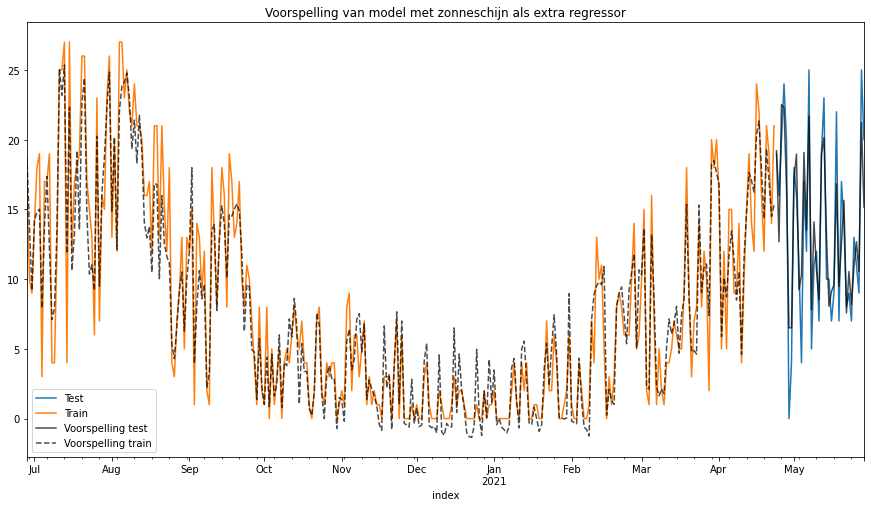

In [133]:
ax = ts_test['teruglevering'].plot(label = 'Test') # Testset 
ts_train['teruglevering'].plot(label = 'Train', ax = ax) # Train set
ts_test['pred_zon2_rev'].plot(color = 'k', alpha = 0.7,
                              label = 'Voorspelling test') # Voorspelling
ts_train['pred_zon2_rev'].plot(ax=ax, style='--', color='k', legend = False, alpha = 0.7,
                               label = 'Voorspelling train') # In sample pred voor train

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model met zonneschijn als extra regressor')
plt.legend()
plt.show()

In eerste instantie is er geen opmerkbare verbetering tov eigen model.

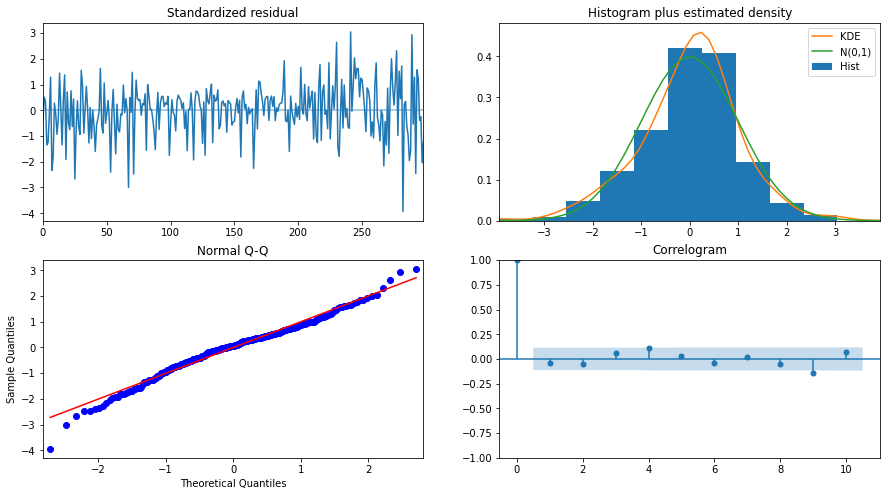

In [134]:
res_zon2.plot_diagnostics()
plt.show()

In [135]:
# Shapiro-Wilk voor residu
shap_zon2 = shapiro(res_zon2.resid())
shap_pval_zon2 = shap_zon2[0]
shap_pval_zon2

0.9840723276138306

In [136]:
mae_zon2 = mean_absolute_error(ts_test['teruglevering'], ts_test['pred_zon2_rev'])
dict_mae['Zon2'] = mae_zon2
dict_mae

{'Fourier1': 6.531391122326459,
 'Zon1': 2.426574453369559,
 'Zon2': 2.4779921921867945}

Zelfde conclusie als bij p en q zelf afgelezen: Er is informatie niet verwerkt in het model, te zien aan de correlogram die nog hoge correlatie heeft bij lag 9. Ook is er nog een patroon te herkennen in de residuen tov de tijd. Residu is wel normaal verdeeld. 

Ondanks dat de AIC van het auto-arima model lager is, is de MAE van het eigen model lager. Dit is niet een heel groot verschil.

Er is grotere fluctuatie in de teruglevering in de de zomermaanden. Het multiplicatieve seizoenspatroon moet opgelost worden, mogelijke oplossingen:

1. Transformatie op teruglevering
2. Transformatie op zonneschijn

### 4.3 Derde model met zonneschijnuren en transformatie op teruglevering
Neem wortel van teruglevering, vervolgens schalen. Misschien lost dit het multiplicatieve probleem op. Voorspelling moet dus eerst terug geschaald worden en dan gekwadrateerd!

In [137]:
# Opnieuw schalen met wortel van teruglevering
ts['teruglevering_sqrt'] = np.sqrt(ts['teruglevering'])

scaler2 = StandardScaler()
sqrt_scaled = scaler2.fit_transform(ts[['teruglevering_sqrt', 'zonneschijn', 'temp']])
ts[['teruglevering_sqrt_sc', 'zonneschijn_sc2', 'temp_sc2']] = sqrt_scaled
ts.head(3)

gas  stroom  teruglevering  temp  zonneschijn  duur_neerslag  \
index                                                                      
2021-05-29  1.0     4.0           20.0   116           73              0   
2021-05-28  0.0     3.0           25.0   121          124              0   
2021-05-27  2.0     4.0            9.0   109           34             84   

            som_neerslag  day_of_week day_of_week_name  day_of_month  ...  \
index                                                                 ...   
2021-05-29             0            5         Saturday            29  ...   
2021-05-28             0            4           Friday            28  ...   
2021-05-27            75            3         Thursday            27  ...   

            zonneschijn_sc anom_if_1 anom_if_2  anom_if_3  \
index                                                       
2021-05-29        0.649640         1         1          1   
2021-05-28        1.939885        -1         1          1   
2021-05-27       -0.337018         1         1          1   

            teruglevering_int_1  teruglevering_int_1_sc  teruglevering_sqrt  \
index                                                                         
2021-05-29                 20.0                1.648142            4.472136   
2021-05-28                 25.0                2.347177            5.000000   
2021-05-27                  9.0                0.110264            3.000000   

            teruglevering_sqrt_sc  zonneschijn_sc2  temp_sc2  
index                                                         
2021-05-29               1.314326         0.649640  0.274087  
2021-05-28               1.665827         1.939885  0.354985  
2021-05-27               0.334040        -0.337018  0.160831  

[3 rows x 27 columns]

In [138]:
# Toevoegen aan train en testset
ts_train[['teruglevering_sqrt_sc', 'zonneschijn_sc2', 'temp_sc2']] = ts[['teruglevering_sqrt_sc', 'zonneschijn_sc2', 'temp_sc2']].loc[ts_model.index.max() - len_test - timedelta(days = 1):]
ts_test[['teruglevering_sqrt_sc', 'zonneschijn_sc2', 'temp_sc2']] = ts[['teruglevering_sqrt_sc', 'zonneschijn_sc2', 'temp_sc2']].loc[:ts_model.index.max() - len_test]

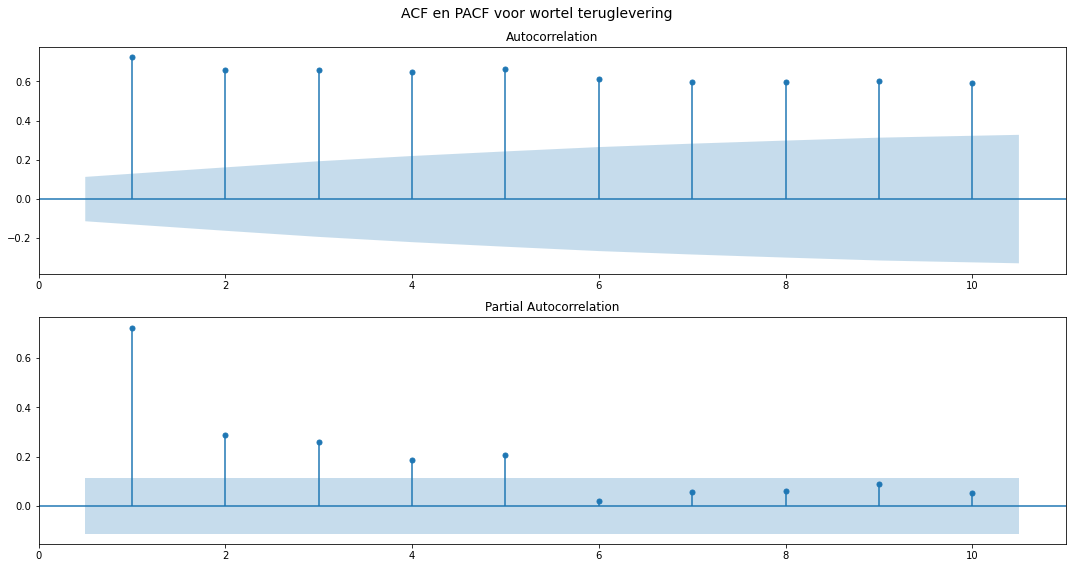

In [139]:
# ACF en PACF
fig, ax = plt.subplots(2,1)

plot_acf(ts_train['teruglevering_sqrt_sc'], lags = 10, zero = False, ax = ax[0])
plot_pacf(ts_train['teruglevering_sqrt_sc'], lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor wortel teruglevering', size = 14)
plt.tight_layout()
plt.show()

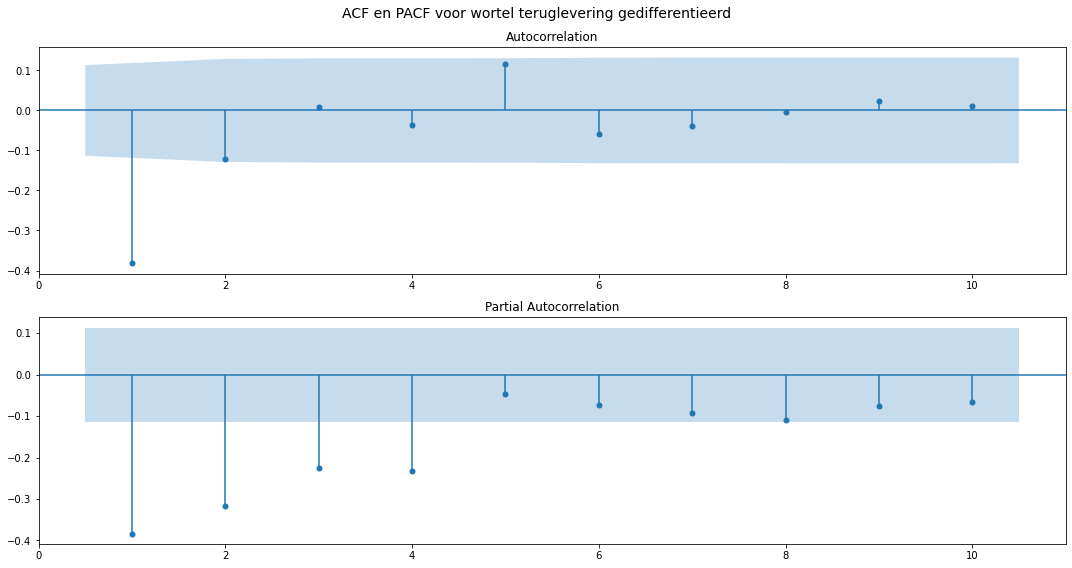

In [140]:
# ACF en PACF voor gedifferentiëerd
fig, ax = plt.subplots(2,1)

plot_acf(ts_train['teruglevering_sqrt_sc'].diff().dropna(), lags = 10, zero = False, ax = ax[0])
plot_pacf(ts_train['teruglevering_sqrt_sc'].diff().dropna(), lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor wortel teruglevering gedifferentieerd', size = 14)
plt.tight_layout()
plt.show()

In [141]:
ts_train['teruglevering_sqrt_sc'].isna().sum()

0

In [142]:
# Auto-ARIMA op de wortel van teruglevering met zonneschijn als extra regressor
res_zon3 = pm.auto_arima(ts_train['teruglevering_sqrt_sc'], 
                        d = 1,
                        start_p = 0, max_p = 2,
                        start_q = 0, max_q = 4,
                        exogenous = ts_train[['zonneschijn_sc']],
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
res_zon3.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=303.021, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=248.418, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=165.595, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=301.022, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=166.374, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=166.071, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=164.921, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=166.723, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=166.729, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=165.575, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=166.151, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=168.752, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=162.977, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=164.130, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=164.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 -76.489
Date:                Sat, 08 Jan 2022   AIC                            162.977
Time:                        13:23:27   BIC                            181.479
Sample:                             0   HQIC                           170.383
                                - 300                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
zonneschijn_sc     0.6455      0.021     30.246      0.000       0.604       0.687
ar.L1             -0.7125      0.196     -3.636      0.000      -1.097      -0.328
ma.L1             -0.0464      0.176     -0.263      0.793      -0.392       0.299
ma.L2             -0.6803      0.143     -4.750      0.000      -0.961      -0.400
sigma2             0.0973      0.009     10.792      0.000       0.080       0.115
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.84   Prob(JB):                         0.36
Heteroskedasticity (H):               1.19   Skew:                            -0.06
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
# Predict voor train
ts_train['pred_zon3'] = res_zon3.predict_in_sample(exogenous = ts_train[['zonneschijn_sc']])

# Terug schalen
rev = scaler2.inverse_transform(ts_train[['pred_zon3', 'zonneschijn_sc', 'temp_sc']])
ts_train['pred_zon3_rev'] = rev.T[0]

# Kwadrateren
ts_train['pred_zon3_sqrd'] = ts_train['pred_zon3_rev']**2
ts_train.head(1)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803   0.93121   

            cos365_1  pred_fourier1  pred_fourier1_rev  pred_zon1  \
index                                                               
2021-04-23 -0.364483       0.382342          10.946094   0.959009   

            pred_zon1_rev  pred_zon2  pred_zon2_rev  teruglevering_sqrt_sc  \
index                                                                        
2021-04-23      15.070833   0.989955      15.292177               1.387867   

            zonneschijn_sc2  temp_sc2  pred_zon3  pred_zon3_rev  \
index                                                             
2021-04-23         1.509803 -0.470167   0.974574       3.961916   

            pred_zon3_sqrd  
index                       
2021-04-23       15.696782

In [144]:
# Predict voor test
ts_test['pred_zon3'] = res_zon3.predict(len(ts_test), exogenous = ts_test[['zonneschijn_sc']])

# Terug schalen
rev = scaler2.inverse_transform(ts_test[['pred_zon3', 'zonneschijn_sc', 'temp_sc']])
ts_test['pred_zon3_rev'] = rev.T[0]

# Kwadrateren
ts_test['pred_zon3_sqrd'] = ts_test['pred_zon3_rev']**2
ts_test.head(1)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-05-29           20.0                 20.0          1.526239   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-05-29                1.648142  0.274087         0.64964  0.546711   

            cos365_1  pred_fourier1  pred_fourier1_rev  pred_zon1  \
index                                                               
2021-05-29 -0.837321        0.30624          10.401756   0.993915   

            pred_zon1_rev  pred_zon2  pred_zon2_rev  teruglevering_sqrt_sc  \
index                                                                        
2021-05-29      15.320499   0.973054      15.171289               1.314326   

            zonneschijn_sc2  temp_sc2  pred_zon3  pred_zon3_rev  \
index                                                             
2021-05-29          0.64964  0.274087   1.006388       4.009693   

            pred_zon3_sqrd  
index                       
2021-05-29       16.077635

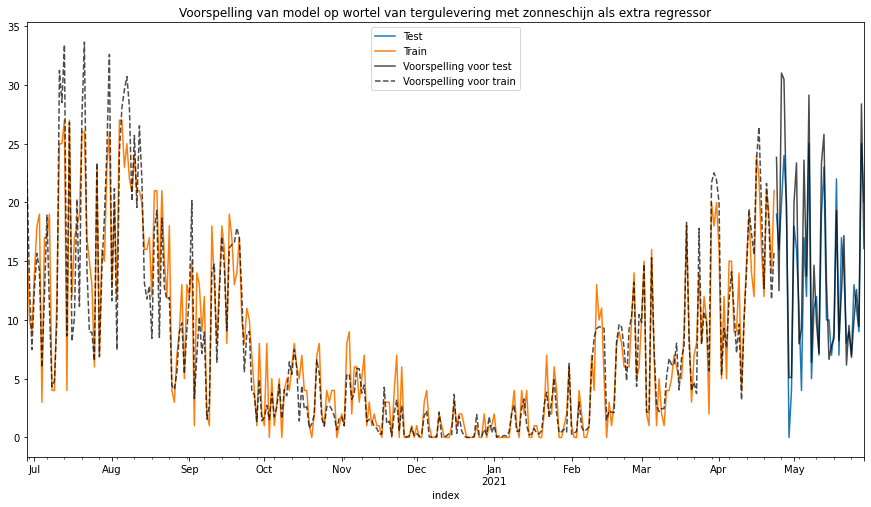

In [145]:
ax = ts_test['teruglevering'].plot(label = 'Test') # Testset 
ts_train['teruglevering'].plot(label = 'Train', ax = ax) # Train set
ts_test['pred_zon3_sqrd'].plot(color = 'k', alpha = 0.7,
                               label = 'Voorspelling voor test') # Voorspelling
ts_train['pred_zon3_sqrd'].plot(ax=ax, style='--', color='k', legend = False, alpha = 0.7,
                                label = "Voorspelling voor train") # In sample pred voor train

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model op wortel van tergulevering met zonneschijn als extra regressor')
plt.legend()
plt.show()

Het probleem dat er negatief voorspeld wordt is nu opgelost.

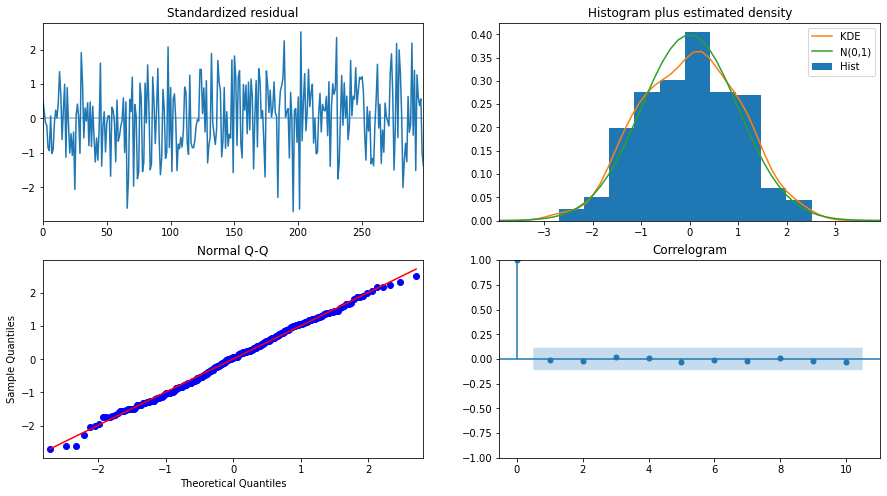

In [146]:
res_zon3.plot_diagnostics()
plt.show()

In [147]:
# Shapiro-Wilk voor residu
shap_zon3 = shapiro(res_zon3.resid())
shap_pval_zon3 = shap_zon3[0]
shap_pval_zon3

0.9948386549949646

In [148]:
mae_zon3 = mean_absolute_error(ts_test['teruglevering'], ts_test['pred_zon3_sqrd'])
dict_mae['Zon3'] = mae_zon3
# Modellen met bijbehorende MAPE, op volgorde van laagste naar hoogste waarde
pd.DataFrame(dict_mae.values(), index = dict_mae.keys(), columns = ["MAE"]).sort_values('MAE')

MAE
Zon1      2.426574
Zon2      2.477992
Zon3      3.128781
Fourier1  6.531391

Model ziet er goed uit. Er is minder goed een patroon te herkennen in de residuen, maar in de winter ziet het er wel anders uit dan daarbuiten. Er is geen autocorrelatie voor de residuen. Residu volgt normaalverdeling. 

De eerste drie modellen voorspelden ook negatieve waarden; dat doet dit model niet meer door de wortel te nemen van teruglevering. De MAE is wel hoger dan die van de voorgaande twee modellen.

Misschien wordt het model beter als er Fourier terms worden toegevoegd aan het Zon3 model.

### 4.4 Vierde model met zonneschijnuren, Fourier Terms en transformatie op teruglevering
#### 4.4.1 Uitzoeken hoe veel Fourier terms er gebruikt moeten worden

In [149]:
# Dictionairy waarin resultaten van auto_arima worden opgeslagen
dict_aa2 = {}

# Sla zonneschijn op in array om toe te kunnen voegen als extra regressor
train_array_exog = np.array(ts_train['zonneschijn_sc']).reshape(-1, 1)
test_array_exog = np.array(ts_test['zonneschijn_sc']).reshape(-1, 1)

# Er wordt een loop doorlopen waarbij 1 tot en met 4 fourier terms worden toegevoegd aan het model
for k in np.arange(2, 10, 2):

    # Train test split voor fourier terms, oude dataframe met fourier terms wordt gebruikt
    fourier_train = np.array(df_exog.iloc[-len(ts_train):, k-2:k])
    
    # Concat zonneschijn met fourier terms
    train_array_exog = np.concatenate((train_array_exog, 
                                       fourier_train), 
                                      axis = 1)
    
#     print(train_array_exog[0])
    # Auto arima doen
    res_aa2 = pm.auto_arima(ts_train['teruglevering_sqrt_sc'], 
                        exogenous = train_array_exog,
                        d = 1, # Één keer differentiëren
                        start_p = 0, max_p = 2, # p is waarschijnlijk 4, dus we zoeken tussen 3 en 5
                        start_q = 1, max_q = 4, # q is waarchijnlik 1, dus we zoeken tussen 0 en 3
                        information_criterion = 'aic',# Beste model wordt gekozen obv aic
                        trace = True, error_action = 'ignore', stepwise = True
                       )
    
    # Beste model in dictionairy gooien
    dict_aa2[k/2] = [res_aa2.order, res_aa2.aic()]
    print()
    
print('\nResultaten:')   
print(dict_aa2)

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=306.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=252.034, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=304.886, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=206.081, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=204.127, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=250.062, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=149.746, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=148.646, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=149.553, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=147.753, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=148.218, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=149.715, Time=0.3

Beste model is bij drie Fourier terms, tweede en derde nog toevoegen aan dataset:

In [150]:
# Kolommen waar FT in staan
aantal_fourier = 3
fourier_cols = df_exog.columns[0:2*aantal_fourier]
fourier_cols

Index(['sin365_1', 'cos365_1', 'sin365_2', 'cos365_2', 'sin365_3', 'cos365_3'], dtype='object')

In [153]:
# Voeg de fourier terms toe aan ts_model
ts_model[fourier_cols] = df_exog[fourier_cols].copy()

# Opnieuw train-test split doen want fourier terms staan er nu niet in 
ts_train[fourier_cols] = ts_model.loc[ts_model.index.max() - len_test - timedelta(days = 1):][fourier_cols].copy()
ts_test[fourier_cols] = ts_model.loc[:ts_model.index.max() - len_test][fourier_cols].copy()
ts_train.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803  0.931210   
2021-04-22                0.809299 -0.437808        0.320754  0.937342   
2021-04-21                1.508334 -0.292193        0.978526  0.943196   

            cos365_1  pred_fourier1  pred_fourier1_rev  ...  \
index                                                   ...   
2021-04-23 -0.364483       0.382342          10.946094  ...   
2021-04-22 -0.348411       1.764127          20.829608  ...   
2021-04-21 -0.332235       1.180099          16.652221  ...   

            teruglevering_sqrt_sc  zonneschijn_sc2  temp_sc2  pred_zon3  \
index                                                                     
2021-04-23               1.387867         1.509803 -0.470167   0.974574   
2021-04-22               0.827905         0.320754 -0.437808   0.620339   
2021-04-21               1.238922         0.978526 -0.292193   1.164974   

            pred_zon3_rev  pred_zon3_sqrd  sin365_2  cos365_2  sin365_3  \
index                                                                     
2021-04-23       3.961916       15.696782 -0.678820 -0.734304 -0.436373   
2021-04-22       3.429947       11.764539 -0.653160 -0.757220 -0.482206   
2021-04-21       4.247848       18.044215 -0.626727 -0.779239 -0.526755   

            cos365_3  
index                 
2021-04-23  0.899766  
2021-04-22  0.876058  
2021-04-21  0.850017  

[3 rows x 24 columns]

#### 4.4.2 Model maken met zonneschijn en drie Fourier terms als extra regressors en transformatie op teruglevering

In [155]:
zon_fourier_cols = ['zonneschijn_sc',
                    'sin365_1', 'cos365_1',
                    'sin365_2', 'cos365_2',
                    'sin365_3', 'cos365_3']

In [159]:
# Auto-ARIMA met zonneschijn en Fourier terms als extra regressors
res_zon_fourier = pm.auto_arima(ts_train['teruglevering_sqrt_sc'], 
                        d = 1,
                        start_p = 0, max_p = 2,
                        start_q = 2, max_q = 4,
                        exogenous = ts_train[zon_fourier_cols],
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
res_zon_fourier.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=153.495, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=314.777, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=259.836, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=145.235, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=312.814, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=151.352, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.128 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -62.617
Date:                Sat, 08 Jan 2022   AIC                            145.235
Time:                        13:27:30   BIC                            182.239
Sample:                             0   HQIC                           160.046
                                - 300                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0023      0.003     -0.888      0.375      -0.007       0.003
zonneschijn_sc     0.6219      0.020     30.609      0.000       0.582       0.662
sin365_1          -0.0747      0.228     -0.327      0.744      -0.522       0.373
cos365_1          -0.8204      0.174     -4.722      0.000      -1.161      -0.480
sin365_2           0.0618      0.052      1.181      0.237      -0.041       0.164
cos365_2          -0.0222      0.109     -0.205      0.838      -0.235       0.191
sin365_3          -0.0282      0.036     -0.789      0.430      -0.098       0.042
cos365_3          -0.0808      0.054     -1.487      0.137      -0.187       0.026
ma.L1             -0.9895      0.032    -30.805      0.000      -1.052      -0.927
sigma2             0.0881      0.009      9.451      0.000       0.070       0.106
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                 2.47
Prob(Q):                              0.18   Prob(JB):                         0.29
Heteroskedasticity (H):               1.19   Skew:                            -0.14
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Bijna alle p-waarden zijn onder 0.05 :)

In [165]:
# Weer fourier terms vermenigvuldigd met hun coeff zodat ze gevisualiseerd kunnen worden

# Krijg coeff
coeff_S1_zf = res_zon_fourier.params()[2]
coeff_C1_zf = res_zon_fourier.params()[3]
coeff_S2_zf = res_zon_fourier.params()[4]
coeff_C2_zf = res_zon_fourier.params()[5]
coeff_S3_zf = res_zon_fourier.params()[6]
coeff_C3_zf = res_zon_fourier.params()[7]

# Vermenigvuldig coeff met bijbehorende term
df_fourier['S1_zf'] = coeff_S1_zf * df_exog[fourier_cols[0]]
df_fourier['C1_zf'] = coeff_C1_zf * df_exog[fourier_cols[1]]
df_fourier['S2_zf'] = coeff_S2_zf * df_exog[fourier_cols[2]]
df_fourier['C2_zf'] = coeff_C2_zf * df_exog[fourier_cols[3]]
df_fourier['S3_zf'] = coeff_S2_zf * df_exog[fourier_cols[4]]
df_fourier['C3_zf'] = coeff_C2_zf * df_exog[fourier_cols[5]]

# Tel terms met dezelfde periode bij elkaar op
df_fourier['Fourier_1_zf'] = df_fourier['S1_zf'] + df_fourier['C1_zf']
df_fourier['Fourier_2_zf'] = df_fourier['S2_zf'] + df_fourier['C2_zf']
df_fourier['Fourier_3_zf'] = df_fourier['S3_zf'] + df_fourier['C3_zf']
# Totale gemodelleerde seizoenscomponent door fourier terms
df_fourier['Fourier_total_zf'] = df_fourier['Fourier_1_zf'] + df_fourier['Fourier_2_zf'] + df_fourier['Fourier_3_zf']

df_fourier.head(3)

S1        C1  Fourier_1     S1_zf     C1_zf     S2_zf  \
index                                                                     
2021-05-29 -0.779546  0.715142  -0.064405 -0.040818  0.686926 -0.056544   
2021-05-28 -0.799968  0.707004  -0.092964 -0.041887  0.679109 -0.057365   
2021-05-27 -0.820154  0.698657  -0.121497 -0.042944  0.671092 -0.058118   

               C2_zf     S3_zf  Fourier_1_zf  Fourier_2_zf     C3_zf  \
index                                                                  
2021-05-29 -0.008938  0.060926      0.646108     -0.065482 -0.003639   
2021-05-28 -0.008233  0.060323      0.637222     -0.065598 -0.004765   
2021-05-27 -0.007518  0.059560      0.628148     -0.065636 -0.005878   

            Fourier_3_zf  Fourier_total_zf  
index                                       
2021-05-29      0.057287          0.637914  
2021-05-28      0.055559          0.627183  
2021-05-27      0.053682          0.616194

In [ ]:
ts_model.head()

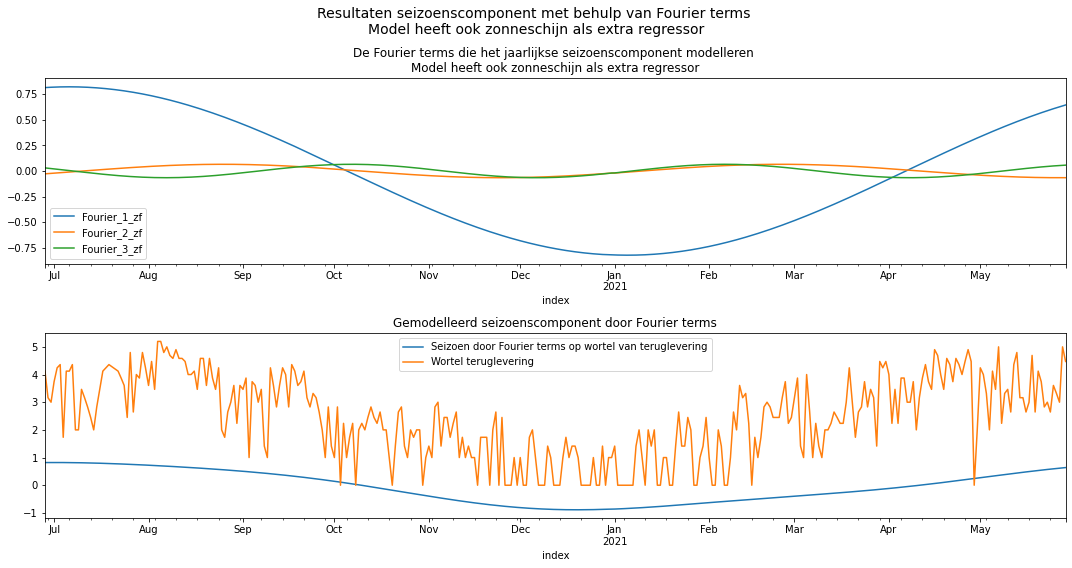

In [167]:
# Plot gemodelleerd seizoen
fig, ax = plt.subplots(2,1)

df_fourier[['Fourier_1_zf', 'Fourier_2_zf', 'Fourier_3_zf']].plot(ax = ax[0])
ax[0].set_title('De Fourier terms die het jaarlijkse seizoenscomponent modelleren \nModel heeft ook zonneschijn als extra regressor')

df_fourier['Fourier_total_zf'].plot(ax = ax[1], label = 'Seizoen door Fourier terms op wortel van teruglevering')
ts['teruglevering_sqrt_sc'] = np.sqrt(ts['teruglevering_int_1'])
ts['teruglevering_sqrt_sc'].plot(ax = ax[1], label = 'Wortel teruglevering')
ax[1].set_title('Gemodelleerd seizoenscomponent door Fourier terms')
ax[1].legend()

fig.suptitle('Resultaten seizoenscomponent met behulp van Fourier terms \nModel heeft ook zonneschijn als extra regressor', size = 14)
plt.tight_layout()
plt.show()

**Gaat weer onder 0? Fourier terms zouden eigenlijk hoger op de y-as moeten beginnen, misschien kunnen we dat ook modelleren**

In [168]:
# Voorspellingen doen
ts_train['pred_zon_fourier'] = res_zon_fourier.predict_in_sample(exogenous = ts_train[zon_fourier_cols])

# Terug schalen
rev = scaler2.inverse_transform(ts_train[['pred_zon_fourier', 'zonneschijn_sc', 'temp_sc']])
ts_train['pred_zon_fourier'] = rev.T[0]

#Kwadrateren
ts_train['pred_zon_fourier_sqrd'] = ts_train['pred_zon_fourier']**2
ts_train.head(3)

teruglevering  teruglevering_int_1  teruglevering_sc  \
index                                                              
2021-04-23           21.0                 21.0          1.658921   
2021-04-22           14.0                 14.0          0.730146   
2021-04-21           19.0                 19.0          1.393557   

            teruglevering_int_1_sc   temp_sc  zonneschijn_sc  sin365_1  \
index                                                                    
2021-04-23                1.787949 -0.470167        1.509803  0.931210   
2021-04-22                0.809299 -0.437808        0.320754  0.937342   
2021-04-21                1.508334 -0.292193        0.978526  0.943196   

            cos365_1  pred_fourier1  pred_fourier1_rev  ...  temp_sc2  \
index                                                   ...             
2021-04-23 -0.364483       0.382342          10.946094  ... -0.470167   
2021-04-22 -0.348411       1.764127          20.829608  ... -0.437808   
2021-04-21 -0.332235       1.180099          16.652221  ... -0.292193   

            pred_zon3  pred_zon3_rev  pred_zon3_sqrd  sin365_2  cos365_2  \
index                                                                      
2021-04-23   0.974574       3.961916       15.696782 -0.678820 -0.734304   
2021-04-22   0.620339       3.429947       11.764539 -0.653160 -0.757220   
2021-04-21   1.164974       4.247848       18.044215 -0.626727 -0.779239   

            sin365_3  cos365_3  pred_zon_fourier  pred_zon_fourier_sqrd  
index                                                                    
2021-04-23 -0.436373  0.899766          4.120471              16.978282  
2021-04-22 -0.482206  0.876058          3.456033              11.944164  
2021-04-21 -0.526755  0.850017          4.197411              17.618258  

[3 rows x 26 columns]

# ?????????? Weet ff niet waarom dit niet werkt

In [178]:
# Voorspelling
ts_test['pred_zon_fourier'] = res_zon_fourier.predict(steps = len(ts_test),
                                                      exogenous = ts_test[zon_fourier_cols])

# Terug schalen
rev = scaler2.inverse_transform(ts_test[['pred_zon3', 'zonneschijn_sc', 'temp_sc']])
ts_test['pred_zon3_rev'] = rev.T[0]

# Kwadrateren
ts_test['pred_zon_fourier_sqrd'] = ts_test['pred_zon_fourier']**2
ts_test.head(3)

ValueError: X array dims (n_rows) != n_periods

In [ ]:
# Plot voorspelling
ax = ts_test['teruglevering_int_1'].plot(label = 'Test') # Testset 
ts_train['teruglevering_int_1'].plot(label = 'Train', ax = ax) # Train set
ts_test['pred_zon_fourier_sqrd'].plot(color = 'k') # Voorspelling
ts_train['pred_zon_fourier_sqrd'].plot(ax=ax, style='--', color='k', legend = False) # In sample pred voor train

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model met zonneschijn als extra regressor, Fourier term voor seizoenscomponent \nVoorspeld op wortel van teruglevering')
plt.legend()
plt.show()

In [ ]:
res_zon_fourier.plot_diagnostics()
plt.show()

In [ ]:
# Shapiro-Wilk voor residu
shap_zon_fourier = shapiro(res_zon_fourier.resid())
shap_pval_zon_fourier = shap_zon_fourier[0]
shap_pval_zon_fourier

In [ ]:
mape_zon_fourier = mean_absolute_percentage_error(ts_test['teruglevering_int_1'], ts_test['pred_zon_fourier_sqrd'])
dict_mape['Zon_fourier'] = mape_zon_fourier
dict_mape

In [ ]:
# Modellen met bijbehorende MAPE, op volgorde van laagste naar hoogste waarde
pd.DataFrame(dict_mape.values(), index = dict_mape.keys(), columns = ["MAPE"]).sort_values('MAPE')

## Bronnen

- https://neptune.ai/blog/anomaly-detection-in-time-series
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a
- https://tanzu.vmware.com/content/blog/forecasting-time-series-data-with-multiple-seasonal-periods